<a href="https://www.kaggle.com/code/anshulm257/titanic-data-visualization-feature-engg-xgb?scriptVersionId=196409860" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

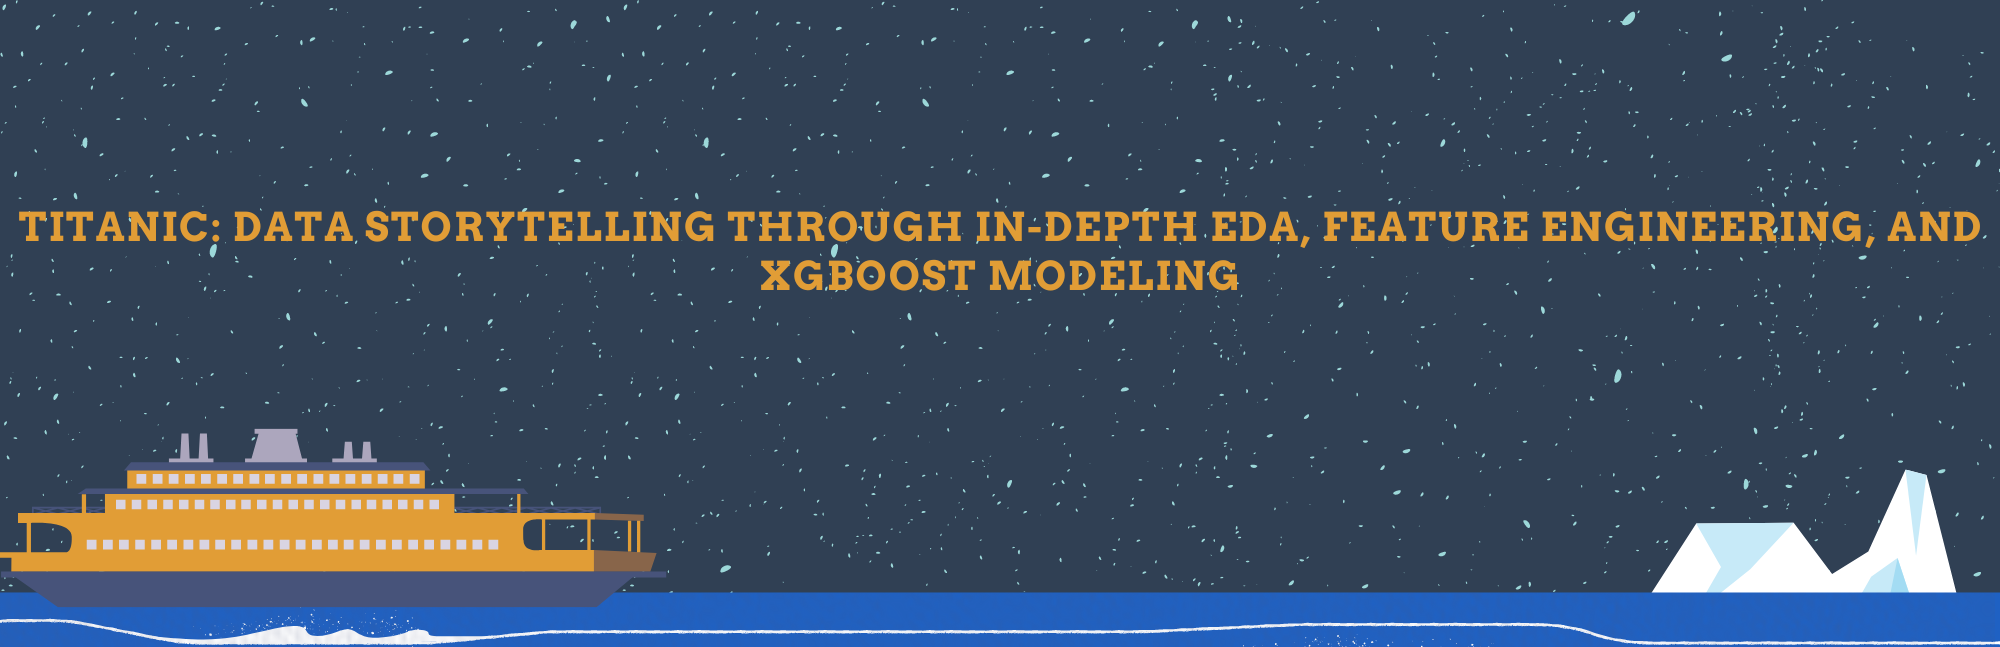

<p style="text-align: center; font-size: 20px; background-color: #E0A628; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #3A6AB7;">
   In this notebook, we explore the Titanic dataset, uncovering the hidden narratives within. We start with a comprehensive Exploratory Data Analysis (EDA) to reveal key patterns and relationships. Through thoughtful feature engineering, we enhance our dataset, preparing it for modeling. Finally, we employ the XGBoost algorithm to build a robust predictive model. This approach not only highlights the technical process but also crafts a compelling data story, illuminating how various elements contribute to predicting survival outcomes.
</p>


## Import libraries 📚

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy.random import seed

seed(11111)
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

## Loading the data 🛳️

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

## Setting Up DataFrame Style ✨

To present our dataset in a visually appealing manner, we will configure a styling setup. This allows us to consistently apply formatting to our data frames, enhancing readability and aesthetics across our analysis. Below, we demonstrate how to set up this style for reuse throughout the notebook.


In [3]:
def style_dataframe(df):
    """
    Applies a consistent styling to the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to style.

    Returns:
    pd.io.formats.style.Styler: The styled DataFrame.
    """
    return df.style.set_table_styles(
        [{
            'selector': 'thead th',
            'props': [
                ('background-color', '#333333'),  # Dark grey background for header
                ('color', '#FFFFFF'),  # White text for header
                ('font-weight', 'bold'),
                ('text-align', 'center'),
                ('border', '1px solid #666666')  # Medium grey border for header
            ]
        }, {
            'selector': 'tbody td',
            'props': [
                ('background-color', '#F0F0F0'),  # Very light grey background for cells
                ('border', '1px solid #DDDDDD'),  # Light grey border for cells
                ('font-weight', 'bold'),
                ('color', '#000000')  # Black text for better readability
            ]
        }]
    ).set_properties(**{'text-align': 'center'}).set_table_attributes('style="width:100%;"').hide(axis='index')


## An overview of the data we are working with 🗃️

In [4]:
# Select a subset (e.g., first 10 rows)
subset_train = train.loc[train.index[:10]]

# Apply styling to the subset
styled_subset_train = style_dataframe(subset_train)

# Display the styled DataFrame
styled_subset_train

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.458300,nan,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.862500,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.075000,nan,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.133300,nan,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.070800,nan,C


## Searching for Missing Values 🕵️

In [5]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We observe a few columns with missing values. We will note these and address them in the subsequent sections.

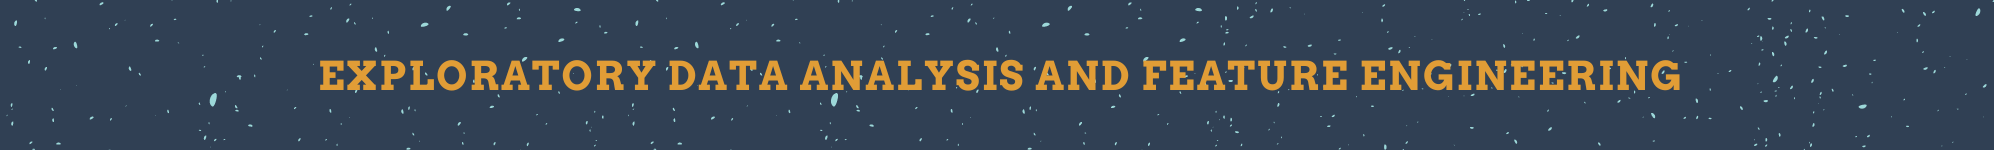

<p style="text-align: center; font-size: 20px; background-color: #E0A628; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #3A6AB7;">
   In this section, we conduct Exploratory Data Analysis (EDA) to uncover key patterns and insights within the dataset. We then apply feature engineering techniques to enhance and transform features, optimizing the dataset for improved model performance.
</p>


## How many made it? ⛴️

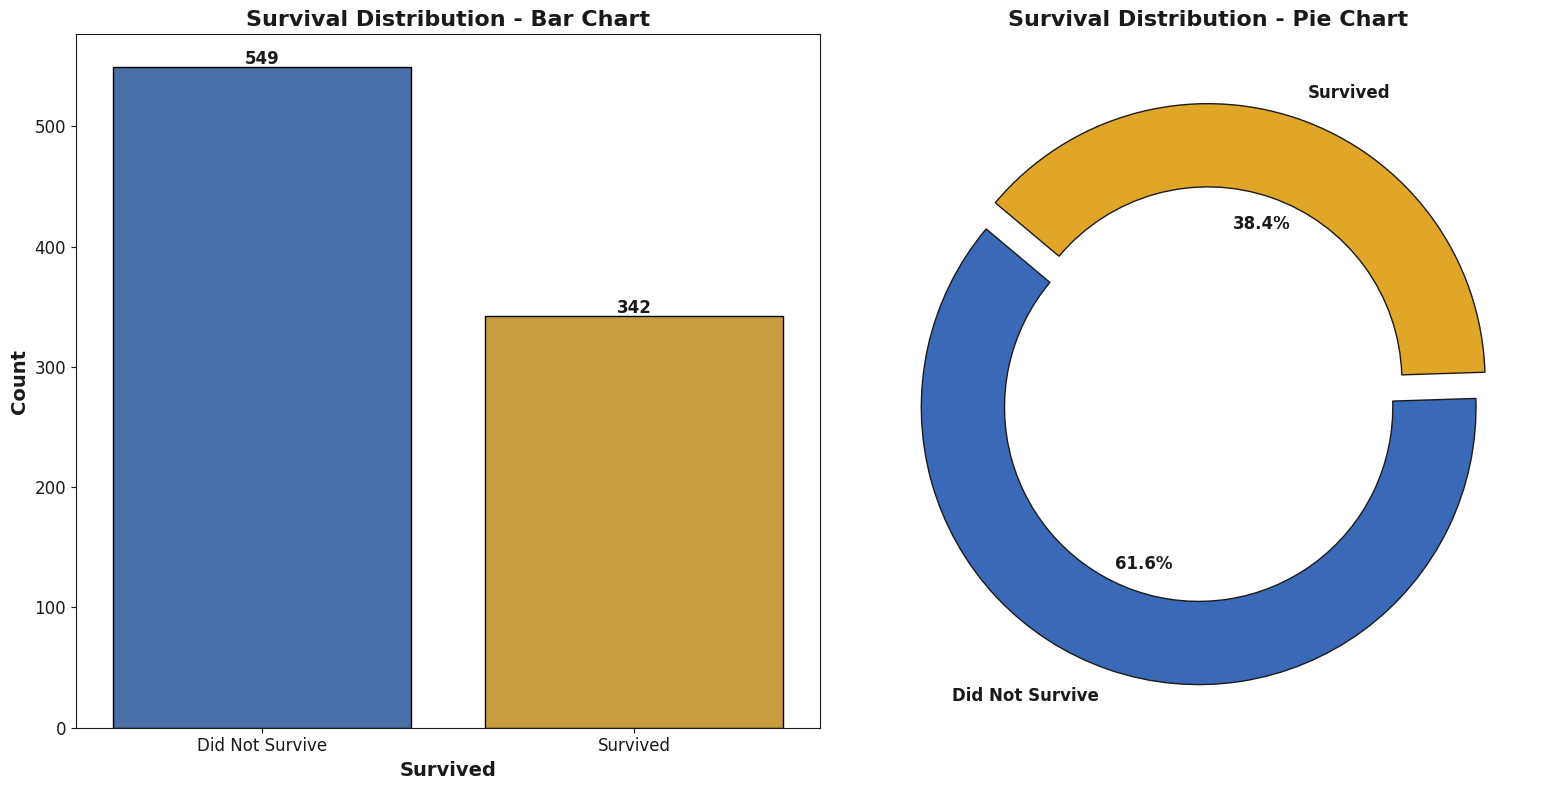

In [6]:
colors = ['#3A6AB7', '#E0A628', '#D4E4EB', '#D4D4D4', '#F0F0F0']

# Calculate the counts
survived_counts = train['Survived'].value_counts()
labels = ['Did Not Survive', 'Survived']

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Chart
sns.barplot(x=survived_counts.index, y=survived_counts.values, palette=colors[:2], ax=ax[0],edgecolor='black')
ax[0].set_xlabel('Survived', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_title('Survival Distribution - Bar Chart', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].set_xticklabels(labels, fontsize=12, color='#1A1A1A')
ax[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center", fontsize=12, fontweight='bold', color='#1A1A1A')

# Pie Chart
ax[1].pie(survived_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors[:2], explode=(0.1, 0),
          textprops={'fontsize': 12, 'color': '#1A1A1A', 'weight': 'bold'}, wedgeprops=dict(width=0.3, edgecolor='#1A1A1A'))
ax[1].set_title('Survival Distribution - Pie Chart', fontsize=16, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()


## Feature Types: What We’ve Got 🧩

**Categorical Features**

Categorical variables have a limited number of unique values and represent distinct categories or groups. These variables are often used for classification purposes and do not have a meaningful order. Features with a smaller number of unique values are considered categorical.

**Continuous Features**

Continuous variables have a large number of unique values and can take on any value within a range. These variables often represent quantities that can be measured. In our dataset, features with a high number of unique values are considered continuous.

In [7]:
unique_counts = train.drop(columns=['Survived','PassengerId']).nunique()
threshold = 12

# Identify continuous and categorical variables
continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# Create DataFrames for continuous and categorical variables
df_continuous = pd.DataFrame({'Continuous Variables': continuous_vars})
df_categorical = pd.DataFrame({'Categorical Variables': categorical_vars})
comparison_df = pd.concat([df_continuous, df_categorical], axis=1)


styled_comparison_df = style_dataframe(comparison_df)

# Display the styled DataFrame
styled_comparison_df

Continuous Variables,Categorical Variables
Name,Pclass
Age,Sex
Ticket,SibSp
Fare,Parch
Cabin,Embarked


## What's in a Name? 📛

In the context of the Titanic dataset, names might not initially seem useful for modeling. However, upon reviewing some excellent analyses, it became evident that names contain valuable information. Specifically, names often include titles such as Mr., Mrs., Master, and Ms., which can provide significant insights. This raises an intriguing question: Did these titles influence survival rates? Additionally, titles can be leveraged to address missing age values. For instance, instead of assigning a generic mean value to the age of a passenger with the title "Master" (typically used for children), we can use the title to more accurately estimate their age. By extracting and analyzing these titles, we can enhance our understanding and improve the accuracy of our predictive models.

In [8]:
full_data = [train, test]
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    

This code snippet extracts titles from passenger names in the Titanic dataset to create a new feature, Title. By using a regular expression, it identifies and isolates titles (e.g., Mr., Mrs., Master) from the Name column. This new feature is then added to both the training and test datasets, potentially providing additional insights for modeling.

## Did Title Influence Survival? 🎩

Exploring how one's social status or role might have affected their chances on the Titanic. Did titles matter when it came to survival?

In [9]:
title_counts = train['Title'].value_counts()

# Create DataFrame for displaying counts
title_counts_df = pd.DataFrame({'Title': title_counts.index, 'Count': title_counts.values})

# Apply styling
styled_title_counts_df = style_dataframe(title_counts_df)

# Display the styled DataFrame
styled_title_counts_df

Title,Count
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Mlle,2
Major,2
Col,2
Countess,1


In the step below, I am consolidating the various titles from the dataset into broader categories. By grouping less common titles like 'Lady,' 'Countess,' and 'Capt' into a single 'Rare' category, I simplify the model and reduce dimensionality. Additionally, I am standardizing similar titles, such as converting 'Mlle' and 'Ms' to 'Miss,' and 'Mme' to 'Mrs.' This helps ensure consistency and improves the quality of the features used in my analysis.

In [10]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [11]:
title_counts = train['Title'].value_counts()

# Create DataFrame for displaying counts
title_counts_df = pd.DataFrame({'Title': title_counts.index, 'Count': title_counts.values})

# Apply styling
styled_title_counts_df = style_dataframe(title_counts_df)

# Display the styled DataFrame
styled_title_counts_df

Title,Count
Mr,517
Miss,185
Mrs,126
Master,40
Rare,23


Title,Count
Mr,517
Miss,185
Mrs,126
Master,40
Rare,23


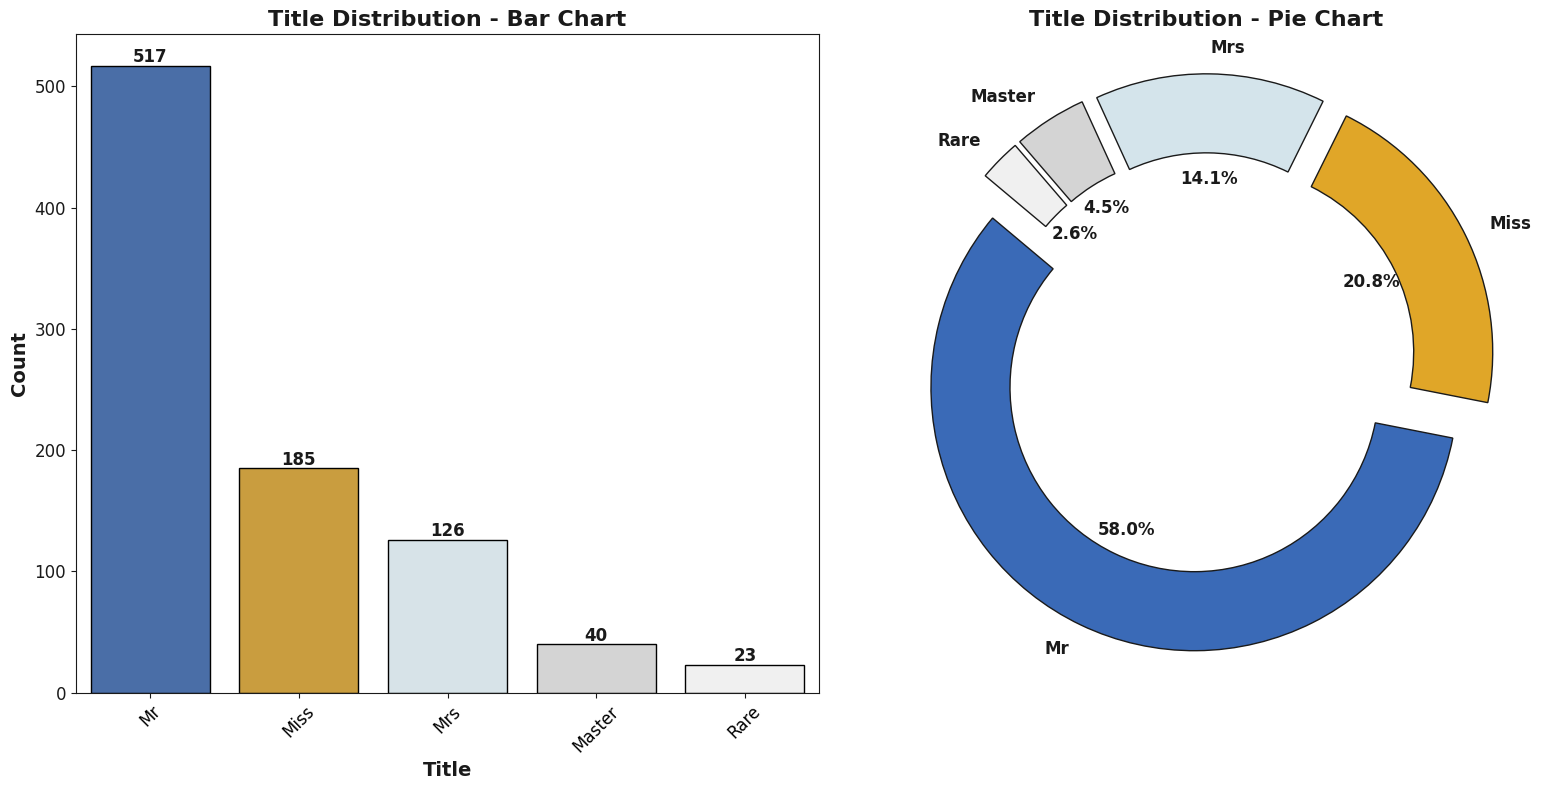

In [12]:
# Define the color scheme
title_counts = train['Title'].value_counts()

# Create DataFrame for displaying counts
title_counts_df = pd.DataFrame({'Title': title_counts.index, 'Count': title_counts.values})

# Apply styling
styled_title_counts_df = style_dataframe(title_counts_df)

# Display the styled DataFrame
display(styled_title_counts_df)


colors = ['#3A6AB7', '#E0A628', '#D4E4EB', '#D4D4D4', '#F0F0F0']


# Calculate the counts
title_counts = train['Title'].value_counts()
labels = title_counts.index

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Chart
sns.barplot(x=title_counts.index, y=title_counts.values, palette=colors[:len(title_counts)], ax=ax[0], edgecolor='black')
ax[0].set_xlabel('Title', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_title('Title Distribution - Bar Chart', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].tick_params(axis='x', labelsize=12, color='#1A1A1A', rotation=45)  # Rotate x labels for better readability
ax[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center", fontsize=12, fontweight='bold', color='#1A1A1A')

# Pie Chart
ax[1].pie(title_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors[:len(title_counts)], explode=(0.1,) * len(title_counts),
          textprops={'fontsize': 12, 'color': '#1A1A1A', 'weight': 'bold'}, wedgeprops=dict(width=0.3, edgecolor='#1A1A1A'))
ax[1].set_title('Title Distribution - Pie Chart', fontsize=16, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()


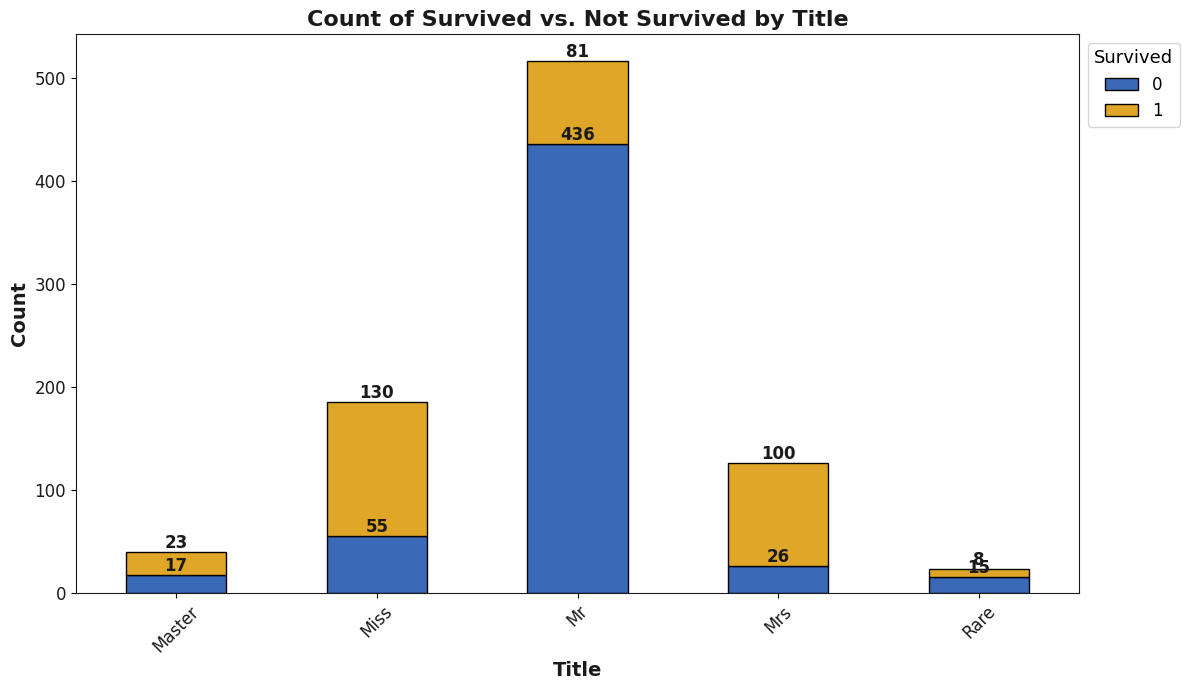

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#3A6AB7', '#E0A628', '#D4E4EB', '#D4D4D4', '#F0F0F0']# Adjust this list to match the color scheme used in previous plots

# Pivot the data to get counts of survived and non-survived for each title
title_counts = train.groupby(['Title', 'Survived']).size().unstack().fillna(0)

# Plot the stacked bar chart with specific colors
ax = title_counts.plot(kind='bar', stacked=True, figsize=(12, 7), edgecolor='black', color=colors[:title_counts.shape[1]])

# Apply style
plt.xlabel('Title', fontsize=14, fontweight='bold', color='#1A1A1A')
plt.ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
plt.title('Count of Survived vs. Not Survived by Title', fontsize=16, fontweight='bold', color='#1A1A1A')
plt.xticks(rotation=45, fontsize=12, color='#1A1A1A')
plt.yticks(fontsize=12, color='#1A1A1A')

# Customize legend
plt.legend(title='Survived', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

# Customize spines
for spine in plt.gca().spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for container in plt.gca().containers:
    plt.gca().bar_label(container, labels=[f'{int(value)}' for value in container.datavalues], fontsize=12, fontweight='bold', color='#1A1A1A')

plt.tight_layout()
plt.show()


### Survival Analysis Based on Titles

**Based on the counts of survival versus non-survival by title, here are some observations:**

- **Male Titles (Mr):** The title **"Mr"** has a much higher count of non-survivors compared to survivors, indicating that males might have had a lower survival rate.

- **Female Titles (Miss, Mrs):** Female titles such as **"Miss**" and **"Mrs**" have higher survival counts, especially **"Miss**" which shows a higher proportion of survivors compared to non-survivors.

- **Child Titles (Master):** The **"Master**" title has a relatively good survival count, suggesting children had a better chance of survival compared to adults in this dataset.

- **Rare Titles:** The **"Rare**" title, with its small sample size, shows a low survival rate, but the small number makes it less significant for broader conclusions.

**Survival Rate Observations:**

- **Higher Survival Rate:** Titles with a higher number of survivors (e.g., **"Miss**") suggest these groups might have had more favorable conditions or higher priority in survival scenarios.

- **Lower Survival Rate:** Titles with a higher count of non-survivors (e.g., **"Mr**") indicate these groups may have faced more challenges or had lower survival chances.

These observations can provide insights into survival trends based on titles, but further analysis might be needed to understand the reasons behind these patterns, including considering other variables like age, class, and sex.


In [14]:
for data in full_data:
    
    data.loc[(data.Age.isnull())&(data.Title=='Mr'),'Age']=33
    data.loc[(data.Age.isnull())&(data.Title=='Mrs'),'Age']=36
    data.loc[(data.Age.isnull())&(data.Title=='Master'),'Age']=5
    data.loc[(data.Age.isnull())&(data.Title=='Miss'),'Age']=22
    data.loc[(data.Age.isnull())&(data.Title=='Rare'),'Age']=46
    
for dataset in full_data:
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

This transformation allows the categorical title data to be used in numerical analyses and machine learning models, which typically require numeric input. The handling of missing values ensures that all entries in the Title column are accounted for, preventing errors during further data processing.

### Filling Missing Age Values Based on Title

This code snippet is used to fill in missing age values (`NaN`) in the `full_data` DataFrame based on the `Title` column. Here’s what each line does:

- **For Male Titles ('Mr'):**  
  Missing ages for individuals with the title *"Mr"* are filled with an average age of **33**.

- **For Female Titles ('Mrs'):**  
  Missing ages for individuals with the title *"Mrs"* are filled with an average age of **36**.

- **For Child Titles ('Master'):**  
  Missing ages for individuals with the title *"Master"* are filled with an average age of **5**, reflecting the typical age of children.

- **For Young Female Titles ('Miss'):**  
  Missing ages for individuals with the title *"Miss"* are filled with an average age of **22**, representing a common age for young adults.

- **For Rare Titles:**  
  Missing ages for individuals with the title *"Rare"* are filled with an average age of **46**, as there are fewer examples to determine a specific age range.

This approach ensures that missing age data is filled in a logical manner based on the individual's title, helping maintain consistency and improve dataset quality for further analysis.


## Age: Just a Number or a Survival Factor? 🔢

Let’s dive into how age might have played a role in survival. Were younger passengers more likely to survive, or did age make little difference?

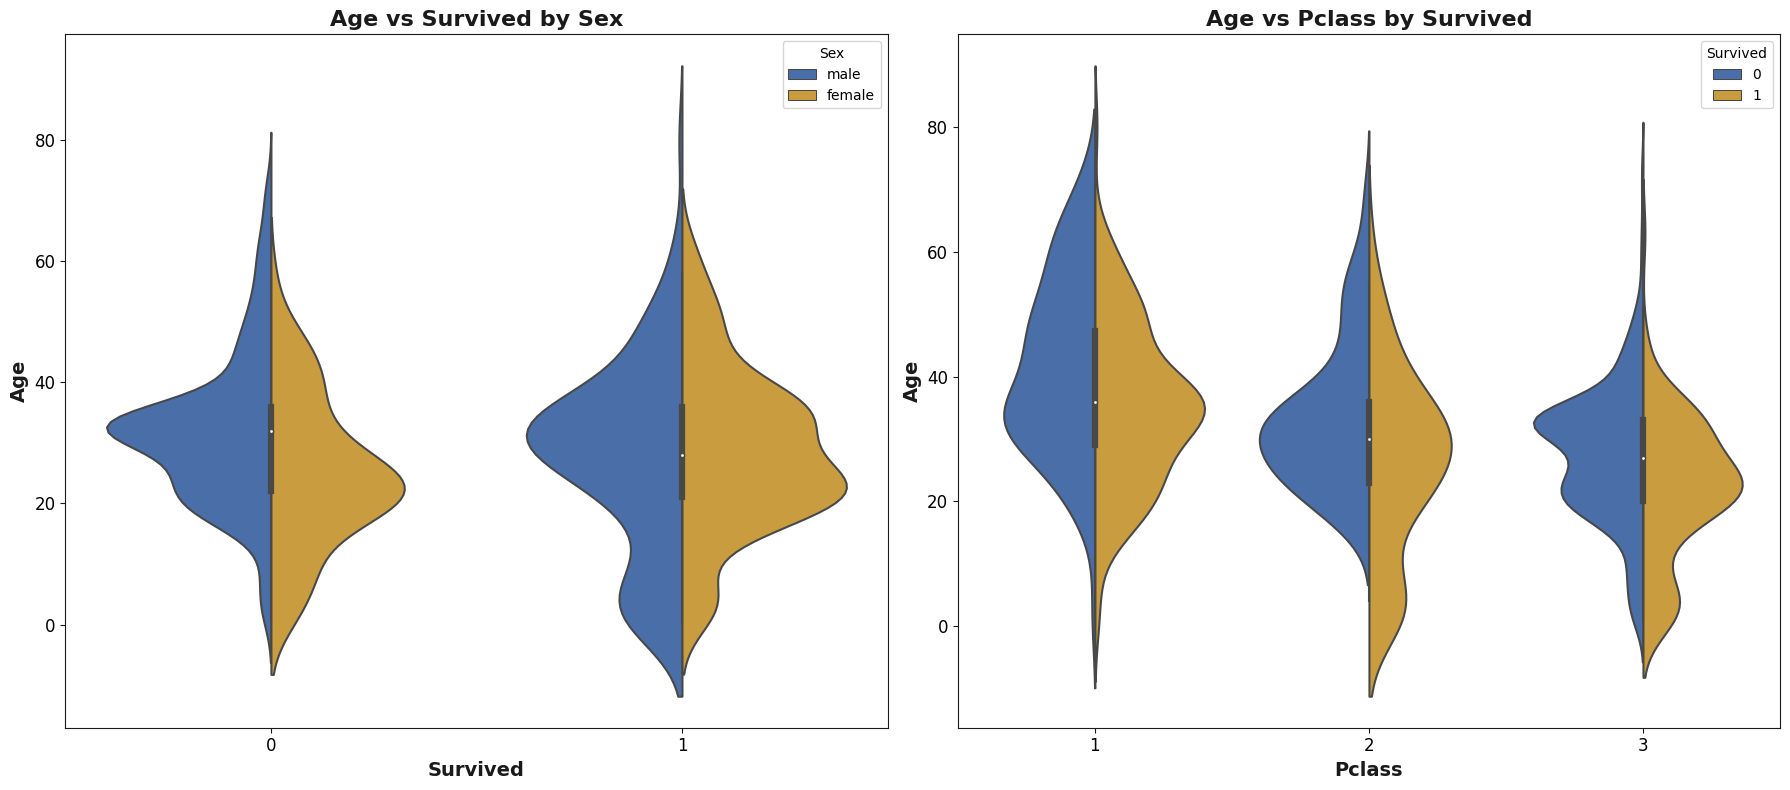

In [15]:
colors = ['#3A6AB7', '#E0A628', '#D4E4EB', '#D4D4D4', '#F0F0F0']

# Create the violin plot
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# Age vs Survived vs Sex
sns.violinplot(x='Survived', y='Age', hue='Sex', data=train, palette=colors[:2], split=True, ax=ax[0])
ax[0].set_title('Age vs Survived by Sex', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].set_xlabel('Survived', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Age', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].tick_params(axis='x', labelsize=12, color='#1A1A1A')
ax[0].tick_params(axis='y', labelsize=12, color='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Age vs Pclass vs Survived
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=train, palette=colors[:2], split=True, ax=ax[1])
ax[1].set_title('Age vs Pclass by Survived', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[1].set_xlabel('Pclass', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[1].set_ylabel('Age', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[1].tick_params(axis='x', labelsize=12, color='#1A1A1A')
ax[1].tick_params(axis='y', labelsize=12, color='#1A1A1A')
for spine in ax[1].spines.values():
    spine.set_edgecolor('#1A1A1A')

plt.tight_layout()
plt.show()

### **Observations from the Violin Plots**

#### **Age vs Survived by Sex (Left Plot):**

- **Survival by Sex:**  
  This plot shows the distribution of ages for different survival statuses (`Survived` = 0 or 1) split by `Sex` (Male and Female).

  - **Males:**  
    The age distribution for males reveals that younger males (below 30) might have had a higher chance of survival compared to older males. The plot likely shows a larger proportion of non-surviving males in older age groups.

  - **Females:**  
    For females, there is often a more balanced or even slightly higher survival rate across age groups. The distribution might show that females of various ages had a better chance of surviving compared to males.

 #### **Age vs Pclass by Survived (Right Plot):**

- **Survival by Pclass:**  
  This plot illustrates the distribution of ages for different passenger classes (`Pclass` = 1, 2, 3) and survival statuses (`Survived` = 0 or 1).

  - **Higher Pclass:**  
    Passengers in higher classes (Pclass 1) generally show a higher survival rate across age groups compared to lower classes. The violin for Pclass 1 might be skewed towards survival, indicating that first-class passengers had a better chance of survival regardless of age.

  - **Lower Pclass:**  
    Passengers in lower classes (Pclass 3) often show a broader age range with a higher proportion of non-survivors. The plot may show that lower-class passengers, regardless of age, had a lower chance of survival.

#### **General Insights:**

- **Age and Survival:**  
  Younger individuals in both plots tend to have a higher survival rate. Older individuals, particularly in lower classes, show lower survival rates.

- **Class Influence:**  
  Higher passenger classes generally have better survival rates, showing the impact of socioeconomic factors on survival chances.

- **Sex Influence:**  
  Females often have a better survival rate compared to males, suggesting gender-related differences in survival outcomes.


In [16]:
for dataset in full_data: 
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 16, 'Age']  = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

By converting age into categorical bins, the model can handle age as a discrete feature rather than a continuous one, which may improve performance and interpretability, especially in classification tasks where age groups may have distinct impacts on the outcome.

Age,Count,Category
0,104,<16
1,384,16-32
2,323,32-48
3,69,48-64
4,11,>64


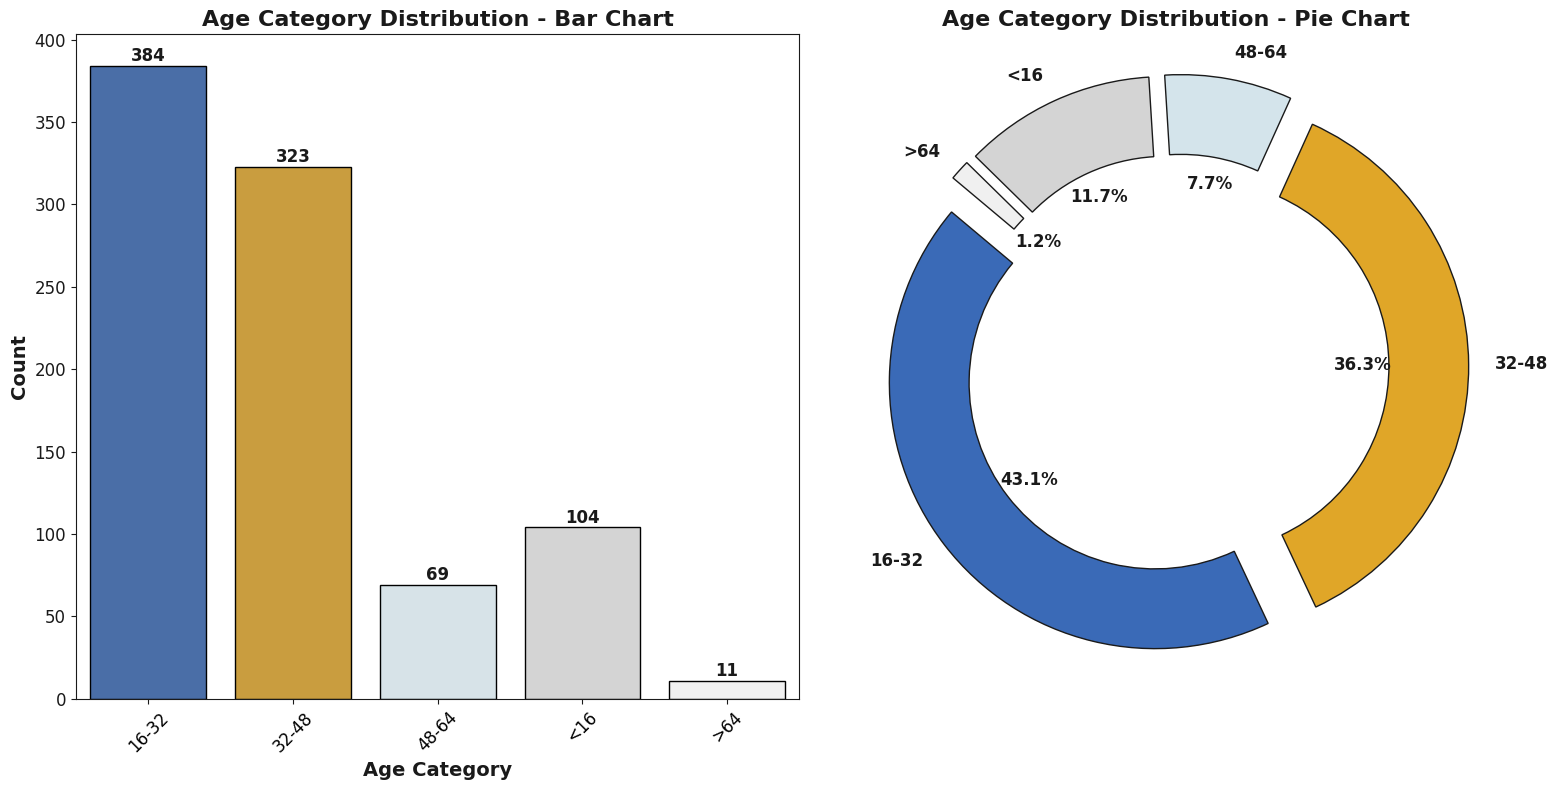

In [17]:
# Calculate the counts for each age
age_counts = train['Age'].value_counts().sort_index()

# Create DataFrame for displaying counts
age_counts_df = pd.DataFrame({'Age': age_counts.index, 'Count': age_counts.values})

# Map age to categories using conditions
def age_to_category(age):
    if age == 0:
        return '<16'
    elif age == 1 :
        return '16-32'
    elif age == 2:
        return '32-48'
    elif age == 3:
        return '48-64'
    else:
        return '>64'

age_counts_df['Category'] = age_counts_df['Age'].apply(age_to_category)

# Apply styling using the reusable function
styled_age_counts_df = style_dataframe(age_counts_df)

# Display the styled DataFrame
display(styled_age_counts_df)

# Calculate the counts for each age category
age_counts = train['Age'].value_counts().sort_index()

# Create DataFrame for displaying counts
age_counts_df = pd.DataFrame({'Age': age_counts.index, 'Count': age_counts.values})

# Map age to categories using conditions
def age_to_category(age):
    if age == 0:
        return '<16'
    elif age == 1:
        return '16-32'
    elif age == 2:
        return '32-48'
    elif age == 3:
        return '48-64'
    else:
        return '>64'

age_counts_df['Category'] = age_counts_df['Age'].apply(age_to_category)

# Aggregate counts by category
category_counts = age_counts_df.groupby('Category')['Count'].sum()

# Define the color scheme
colors = ['#3A6AB7', '#E0A628', '#D4E4EB', '#D4D4D4', '#F0F0F0']

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Chart
sns.barplot(x=category_counts.index, y=category_counts.values, palette=colors[:len(category_counts)], ax=ax[0], edgecolor='black')
ax[0].set_xlabel('Age Category', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_title('Age Category Distribution - Bar Chart', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].tick_params(axis='x', labelsize=12, color='#1A1A1A', rotation=45)  # Rotate x labels for better readability
ax[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center", fontsize=12, fontweight='bold', color='#1A1A1A')

# Pie Chart
ax[1].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors[:len(category_counts)], explode=(0.1,) * len(category_counts),
          textprops={'fontsize': 12, 'color': '#1A1A1A', 'weight': 'bold'}, wedgeprops=dict(width=0.3, edgecolor='#1A1A1A'))
ax[1].set_title('Age Category Distribution - Pie Chart', fontsize=16, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()

## Gender: Did It Tip the Scales? 🚻

Let's explore how gender may have influenced survival chances on the Titanic. This breakdown looks at whether being male or female made a difference when it came to surviving the iceberg.

Sex,Count
male,577
female,314


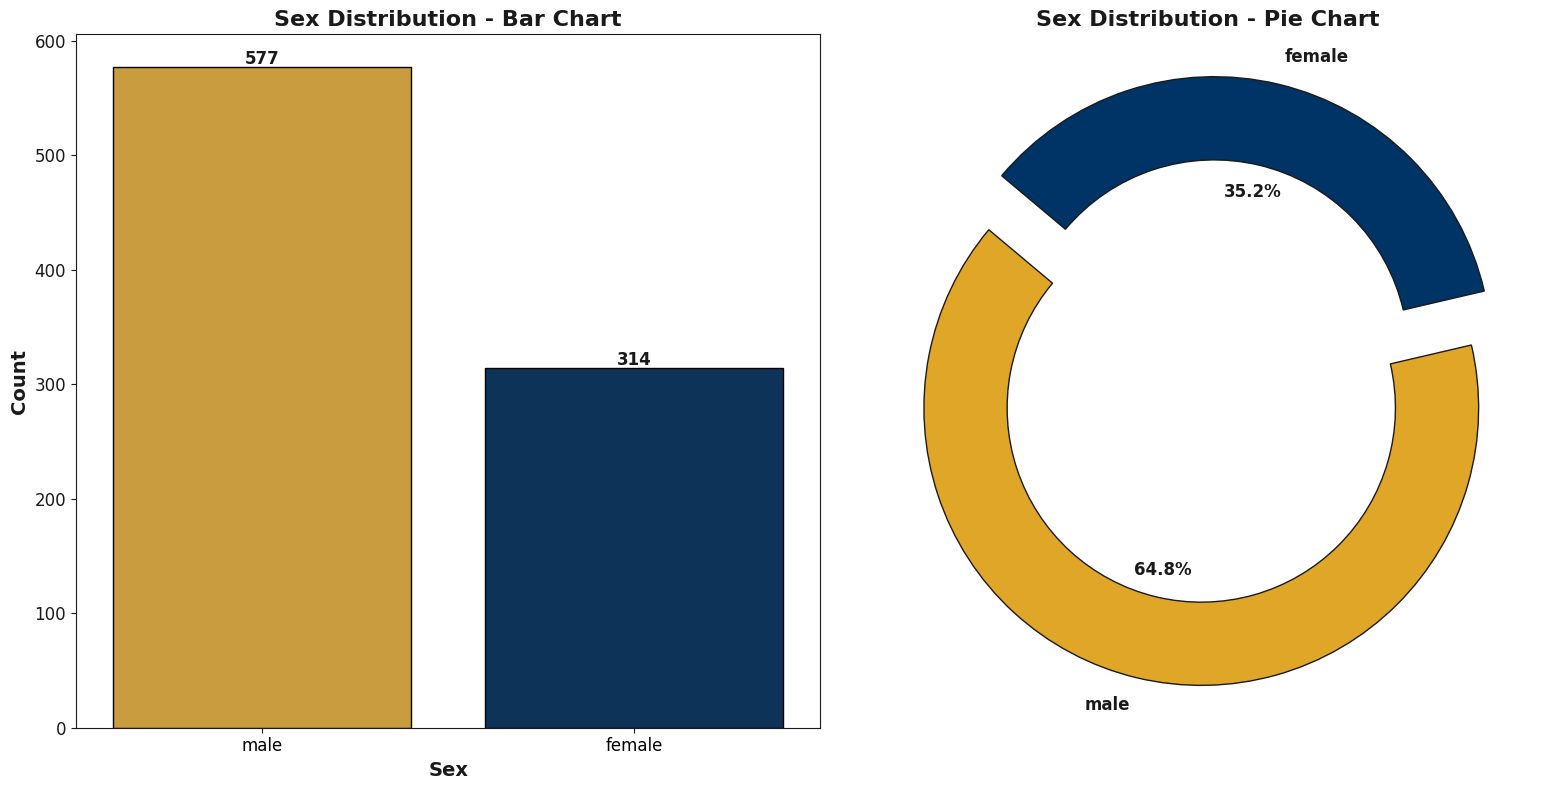

In [18]:
# Calculate the counts for 'Sex'
sex_counts = train['Sex'].value_counts()

# Create a DataFrame for displaying counts
sex_counts_df = pd.DataFrame({'Sex': sex_counts.index, 'Count': sex_counts.values})

# Assuming you have a style_dataframe function defined elsewhere
styled_sex_counts_df = style_dataframe(sex_counts_df)

# Display the styled DataFrame
display(styled_sex_counts_df)


# Define the color scheme
colors = ['#E0A628', '#003366']  # Colors for Male and Female

# Calculate the counts for 'Sex'
sex_counts = train['Sex'].value_counts()
labels = sex_counts.index

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Chart
sns.barplot(x=sex_counts.index, y=sex_counts.values, palette=colors[:len(sex_counts)], ax=ax[0], edgecolor='black')
ax[0].set_xlabel('Sex', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_title('Sex Distribution - Bar Chart', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].tick_params(axis='x', labelsize=12, color='#1A1A1A', rotation=0)  # Rotate x labels for better readability
ax[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center", fontsize=12, fontweight='bold', color='#1A1A1A')

# Pie Chart
ax[1].pie(sex_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors[:len(sex_counts)], explode=(0.1,) * len(sex_counts),
          textprops={'fontsize': 12, 'color': '#1A1A1A', 'weight': 'bold'}, wedgeprops=dict(width=0.3, edgecolor='#1A1A1A'))
ax[1].set_title('Sex Distribution - Pie Chart', fontsize=16, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()


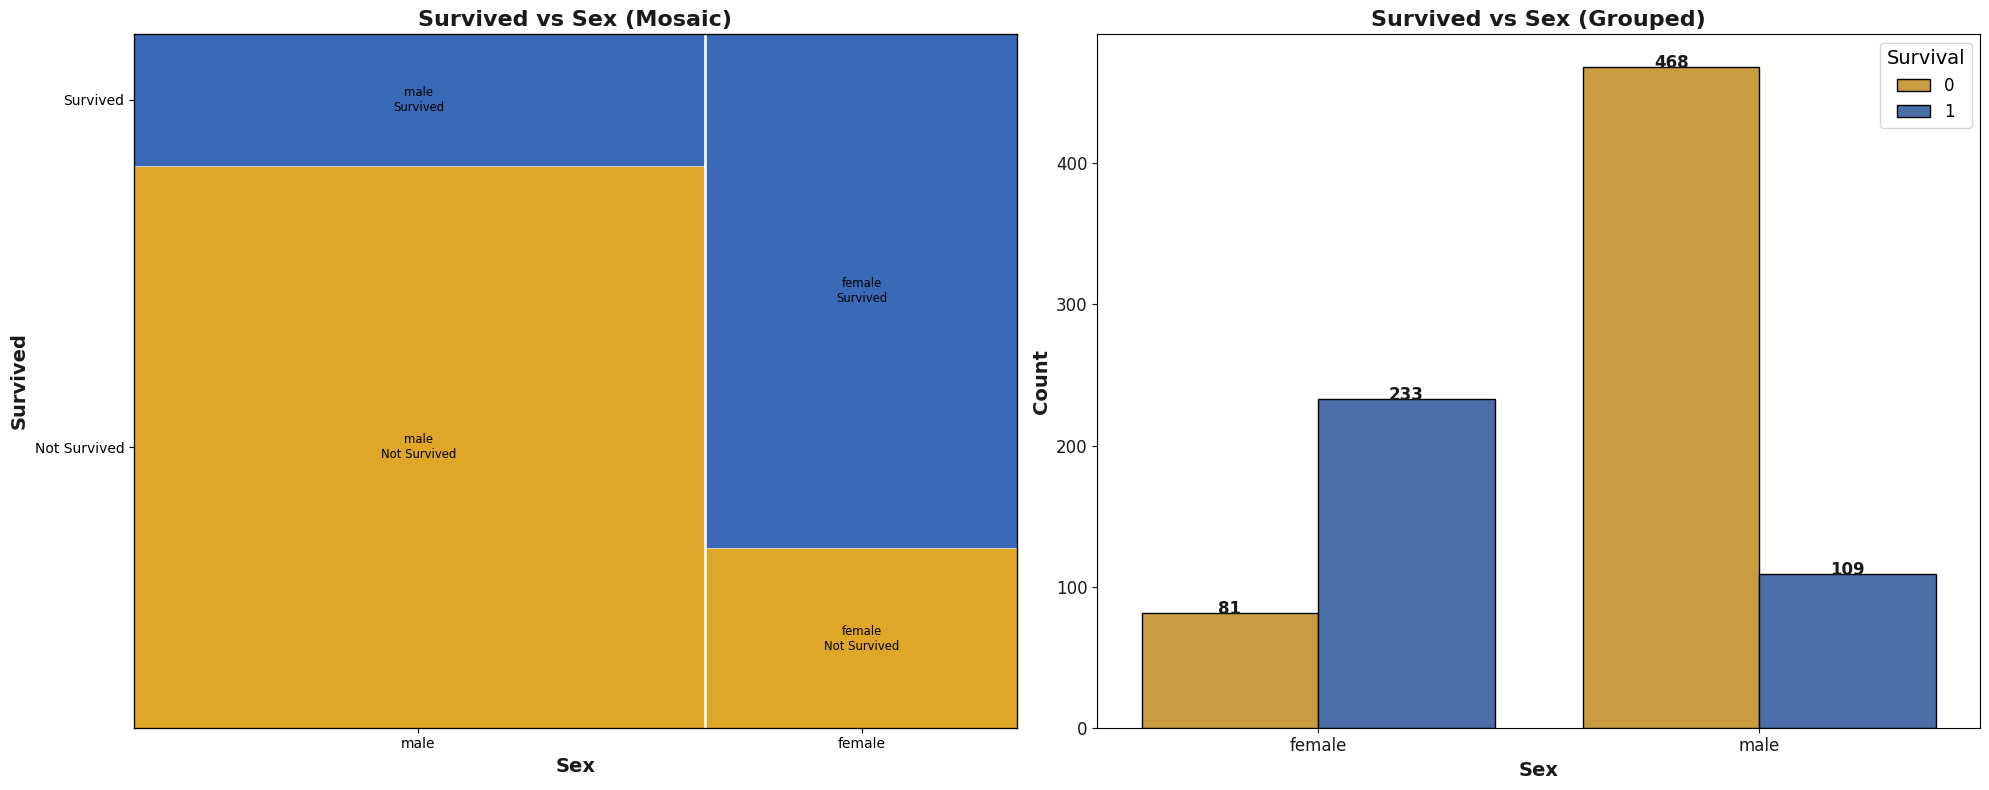

In [19]:
from statsmodels.graphics.mosaicplot import mosaic

# Define the color scheme
colors = ['#87CEEB', '#E0A628', '#3A6AB7', '#D4D4D4', '#F0F0F0']

# Prepare the data for mosaic plot
data = train[['Sex', 'Survived']]
data['Survived'] = data['Survived'].map({0: 'Not Survived', 1: 'Survived'})
props = lambda key: {'color': colors[2] if key[1] == 'Survived' else colors[1]}

# Create a DataFrame for survived counts by sex
survived_by_sex = train.groupby('Sex')['Survived'].value_counts().unstack().fillna(0).reset_index()

# Melt the DataFrame to long format for seaborn
survived_by_sex_melted = survived_by_sex.melt(id_vars='Sex', value_vars=[0, 1], var_name='Survived', value_name='Count')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Mosaic Plot
mosaic(data, ['Sex', 'Survived'], properties=props, ax=axes[0])
axes[0].set_title('Survived vs Sex (Mosaic)', fontsize=16, fontweight='bold', color='#1A1A1A')
axes[0].set_xlabel('Sex', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[0].set_ylabel('Survived', fontsize=14, fontweight='bold', color='#1A1A1A')

# Grouped Bar Chart
sns.barplot(x='Sex', y='Count', hue='Survived', data=survived_by_sex_melted, palette=colors[1:3], ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Sex', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[1].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[1].set_title('Survived vs Sex (Grouped)', fontsize=16, fontweight='bold', color='#1A1A1A')
axes[1].tick_params(axis='x', labelsize=12, colors='#1A1A1A')
axes[1].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
axes[1].legend(title='Survival', fontsize=12, title_fontsize=14, loc='upper right')

# Add labels to each bar segment
for p in axes[1].patches:
    height = p.get_height()
    if height > 0:
        axes[1].annotate(f'{int(height)}', 
                         (p.get_x() + p.get_width() / 2, p.get_height() + 3), 
                         ha='center', va='center', 
                         fontsize=12, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()


### Observations from the Data

**Higher Survival Rate for Females:**

- **Survivors:** Out of 314 females, 233 survived.
- **Non-Survivors:** Only 81 females did not survive.
- **Insight:** Females had a significantly higher chance of survival compared to males.

**Lower Survival Rate for Males:**

- **Survivors:** Out of 577 males, only 109 survived.
- **Non-Survivors:** A majority of 468 males did not survive.
- **Insight:** Males had a much lower chance of survival compared to females.

**Sex-Based Differences in Survival:**

- **Observation:** The data shows a significant difference in survival rates between sexes, with females having a notably higher chance of survival compared to males.
- **Potential Explanation:** This difference may be attributed to various factors, including the "women and children first" policy during the evacuation process.



In [20]:
for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

This line of code converts categorical gender data into numerical format, where 'female' is mapped to 0 and 'male' to 1, to facilitate model training.

## Class Act: Did Your Ticket Determine Your Fate? 🎟️

Discover how passenger class (Pclass) might have affected survival odds. Were those in higher classes more likely to survive, or did class have less impact than expected? 

Pclass,Count
3,491
1,216
2,184


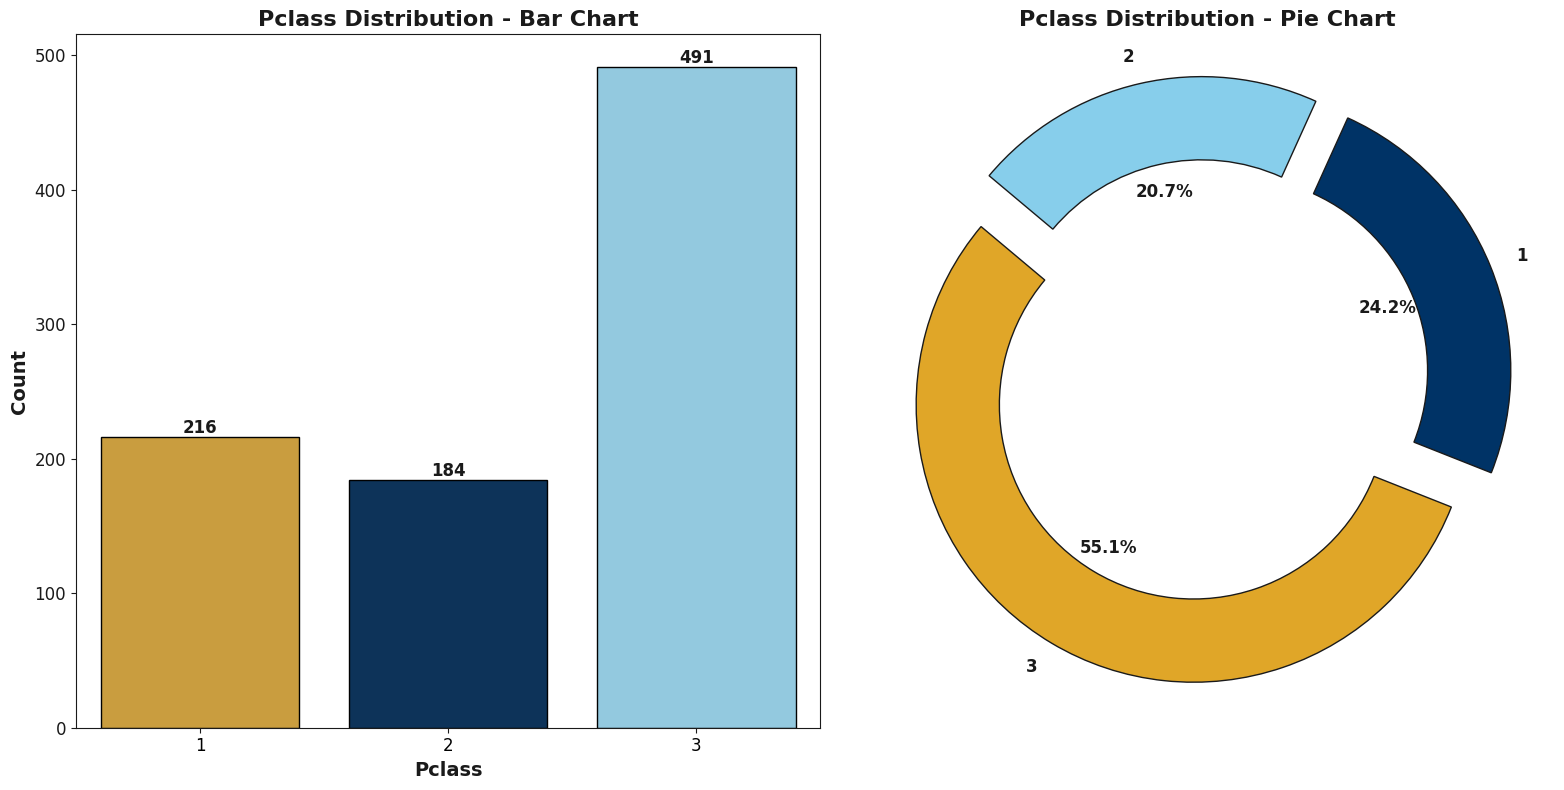

In [21]:
pclass_counts = train['Pclass'].value_counts()

# Create a DataFrame for displaying counts
pclass_counts_df = pd.DataFrame({'Pclass': pclass_counts.index, 'Count': pclass_counts.values})

styled_pclass_counts_df = style_dataframe(pclass_counts_df)

# Display the styled DataFrame
display(styled_pclass_counts_df)


# Define the color scheme
colors = ['#E0A628', '#003366', '#87CEEB']

# Calculate the counts for 'Pclass'
pclass_counts = train['Pclass'].value_counts()
labels = pclass_counts.index

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Chart
sns.barplot(x=pclass_counts.index, y=pclass_counts.values, palette=colors[:len(pclass_counts)], ax=ax[0], edgecolor='black')
ax[0].set_xlabel('Pclass', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_title('Pclass Distribution - Bar Chart', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].tick_params(axis='x', labelsize=12, color='#1A1A1A', rotation=0)  # Rotate x labels for better readability
ax[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center", fontsize=12, fontweight='bold', color='#1A1A1A')

# Pie Chart
ax[1].pie(pclass_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors[:len(pclass_counts)], explode=(0.1,) * len(pclass_counts),
          textprops={'fontsize': 12, 'color': '#1A1A1A', 'weight': 'bold'}, wedgeprops=dict(width=0.3, edgecolor='#1A1A1A'))
ax[1].set_title('Pclass Distribution - Pie Chart', fontsize=16, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()

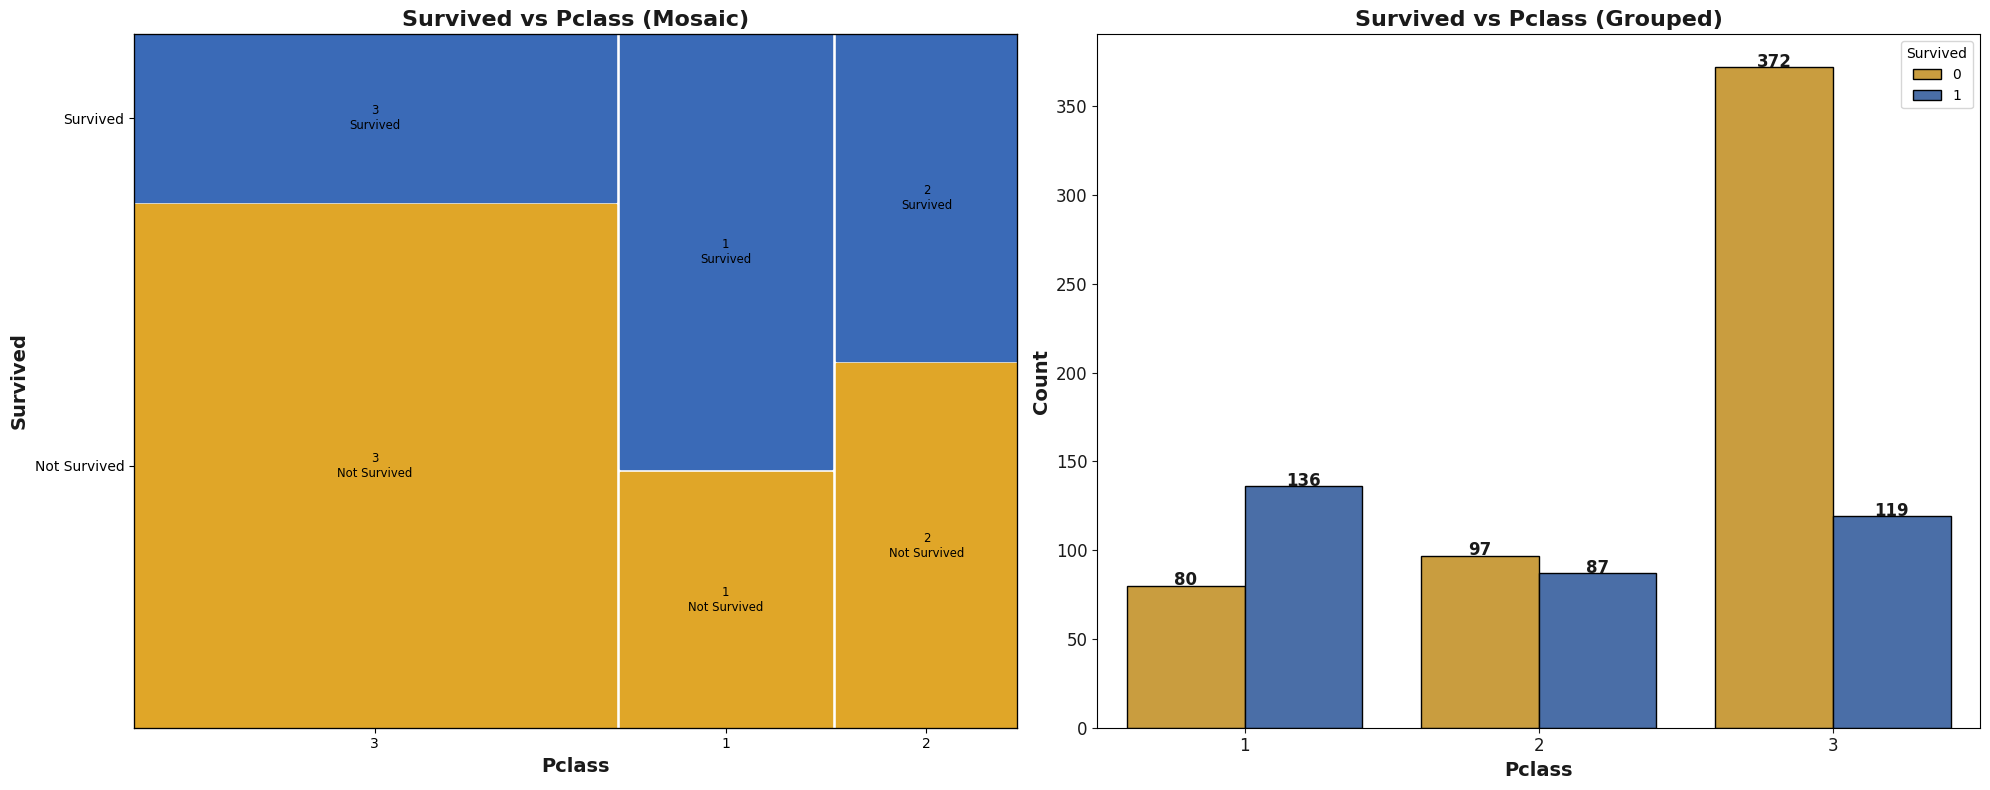

In [22]:
from statsmodels.graphics.mosaicplot import mosaic


colors = ['#87CEEB', '#E0A628', '#3A6AB7', '#D4D4D4', '#F0F0F0']

# Prepare the data for mosaic plot
data = train[['Pclass', 'Survived']]
data['Survived'] = data['Survived'].map({0: 'Not Survived', 1: 'Survived'})
props = lambda key: {'color': colors[2] if key[1] == 'Survived' else colors[1]}

# Create a DataFrame for survived counts by class
survived_by_class = train.groupby('Pclass')['Survived'].value_counts().unstack().fillna(0).reset_index()

# Melt the DataFrame to long format for seaborn
survived_by_class_melted = survived_by_class.melt(id_vars='Pclass', value_vars=[0, 1], var_name='Survived', value_name='Count')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Mosaic Plot
mosaic(data, ['Pclass', 'Survived'], properties=props, ax=axes[0])
axes[0].set_title('Survived vs Pclass (Mosaic)', fontsize=16, fontweight='bold', color='#1A1A1A')
axes[0].set_xlabel('Pclass', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[0].set_ylabel('Survived', fontsize=14, fontweight='bold', color='#1A1A1A')

# Grouped Bar Chart
sns.barplot(x='Pclass', y='Count', hue='Survived', data=survived_by_class_melted, palette=colors[1:3], ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Pclass', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[1].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[1].set_title('Survived vs Pclass (Grouped)', fontsize=16, fontweight='bold', color='#1A1A1A')
axes[1].tick_params(axis='x', labelsize=12, colors='#1A1A1A')
axes[1].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
#axes.legend(['Not Survived', 'Survived'], title='Survival', fontsize=12, title_fontsize=14, loc='upper right')

# Add labels to each bar segment
for p in axes[1].patches:
    height = p.get_height()
    if height > 0:
        axes[1].annotate(f'{int(height)}', 
                         (p.get_x() + p.get_width() / 2, p.get_height() + 3), 
                         ha='center', va='center', 
                         fontsize=12, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()


### **Survival Distribution:**

- **Observation:** The survival rates decrease as the class number increases. First-class passengers had the best chances of survival, while third-class passengers had the poorest chances.

### **Implications:**

- **Social and Economic Factors:** The higher survival rates for first-class passengers may reflect socio-economic factors, such as access to lifeboats and priority in evacuation.

- **Access and Safety:** The disparity in survival rates might be attributed to the better access to safety measures and resources available to first-class passengers compared to those in lower classes.


## Money Matters? The Fare Factor in Titanic Survival 💸

Ever wondered if a passenger's wallet could have saved them from the icy waters of the Atlantic? Let’s dive into how fare might have shaped survival chances on the Titanic, and see if those with deeper pockets had a better shot at making it to safety.

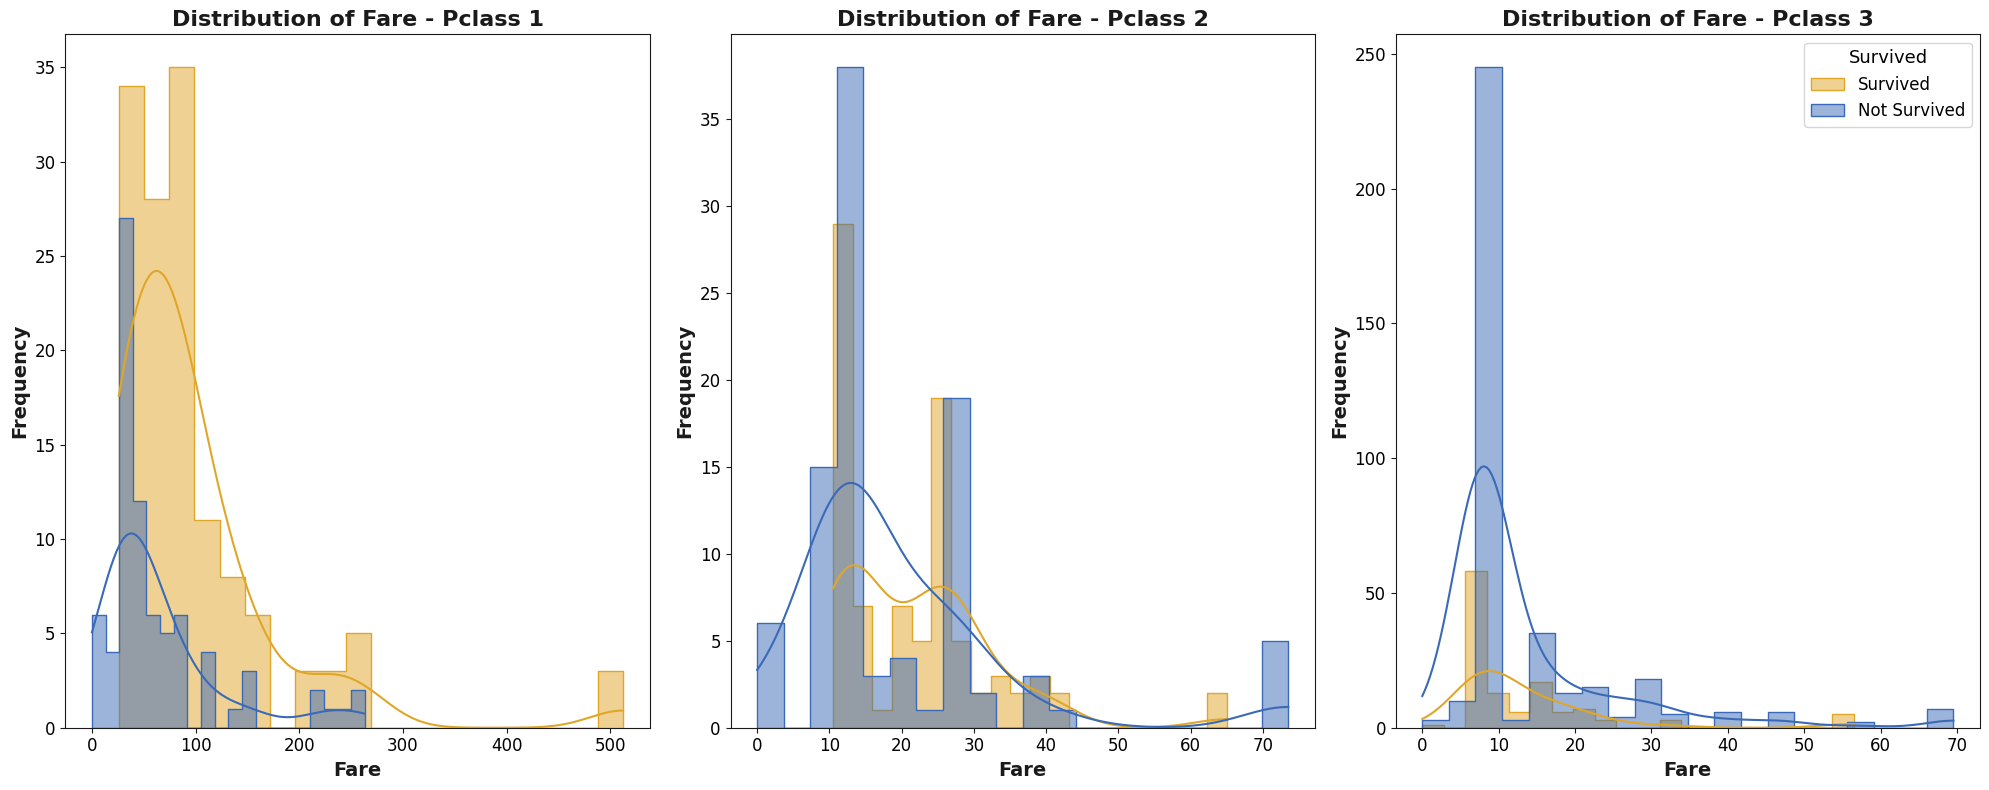

In [23]:
colors = ['#3A6AB7', '#E0A628']

# Create a figure with three subplots with independent y-axis scales
fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=False)

# Titles for each subplot
pclass_titles = ['Pclass 1', 'Pclass 2', 'Pclass 3']

# Loop through each Pclass and plot
for i, pclass in enumerate([1, 2, 3]):
    ax = axes[i]
    # Filter the data for the current Pclass
    data = train[train['Pclass'] == pclass]
    
    # Plot histograms for each Survived category
    sns.histplot(data[data['Survived'] == 1]['Fare'], kde=True, color=colors[1], label='Survived', ax=ax, bins=20, element='step')
    sns.histplot(data[data['Survived'] == 0]['Fare'], kde=True, color=colors[0], label='Not Survived', ax=ax, bins=20, element='step')
    
    # Set labels and title
    ax.set_xlabel('Fare', fontsize=14, fontweight='bold', color='#1A1A1A')
    ax.set_ylabel('Frequency', fontsize=14, fontweight='bold', color='#1A1A1A')
    ax.set_title(f'Distribution of Fare - {pclass_titles[i]}', fontsize=16, fontweight='bold', color='#1A1A1A')
    ax.tick_params(axis='x', labelsize=12, color='#1A1A1A')
    ax.tick_params(axis='y', labelsize=12, color='#1A1A1A')
    for spine in ax.spines.values():
        spine.set_edgecolor('#1A1A1A')

# Add a legend to the last subplot
axes[2].legend(title='Survived', title_fontsize='13', fontsize='12')

plt.tight_layout()
plt.show()

### **General Trends:**

- **Higher Fares and Survival:** Higher fare values are more strongly associated with survival in first and second classes. Survivors in these classes tended to have higher fares compared to non-survivors.
- **Lower Fares and Survival:** In third class, the fare values for survivors are lower and more concentrated around the lower end. This suggests that lower fare values are more common among survivors in this class.

### **Class Discrepancies:**

- **Class 1:** Higher fares generally correlate with higher survival rates. This indicates that those who paid more for their tickets had better chances of survival.
- **Class 2:** The fare distributions are less extreme than in Class 1, with a more balanced survival rate across fare ranges.
- **Class 3:** The survival rate is lower, and the fare distribution is skewed towards lower fares, reflecting that lower-income passengers in third class had worse survival chances.


In [24]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

Filling out missing values

In [25]:
for dataset in full_data:     
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']         = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']   = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

**Why Binning Fare?**

We're turning Fare into categories because:

- **Simplicity:** It’s easier to work with simpler categories instead of continuous numbers.
- **Model Boost:** Some models handle categorical data better and can perform more effectively with these bins.
- **Outliers:** Reduces the impact of extreme fare values that could skew results.

So, by grouping fares into categories (like 0, 1, and 2), we're making the data more manageable and potentially improving our model's performance!


## Embarked: Did the Port of Entry Affect Titanic Destiny?" 🌊

Here we explore how the port where passengers boarded the Titanic might have influenced their fate. Did boarding from a particular port have any impact on their chances of survival? 

In [26]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

Filling out missing values with 'S'

Embarked,Count
S,646
C,168
Q,77


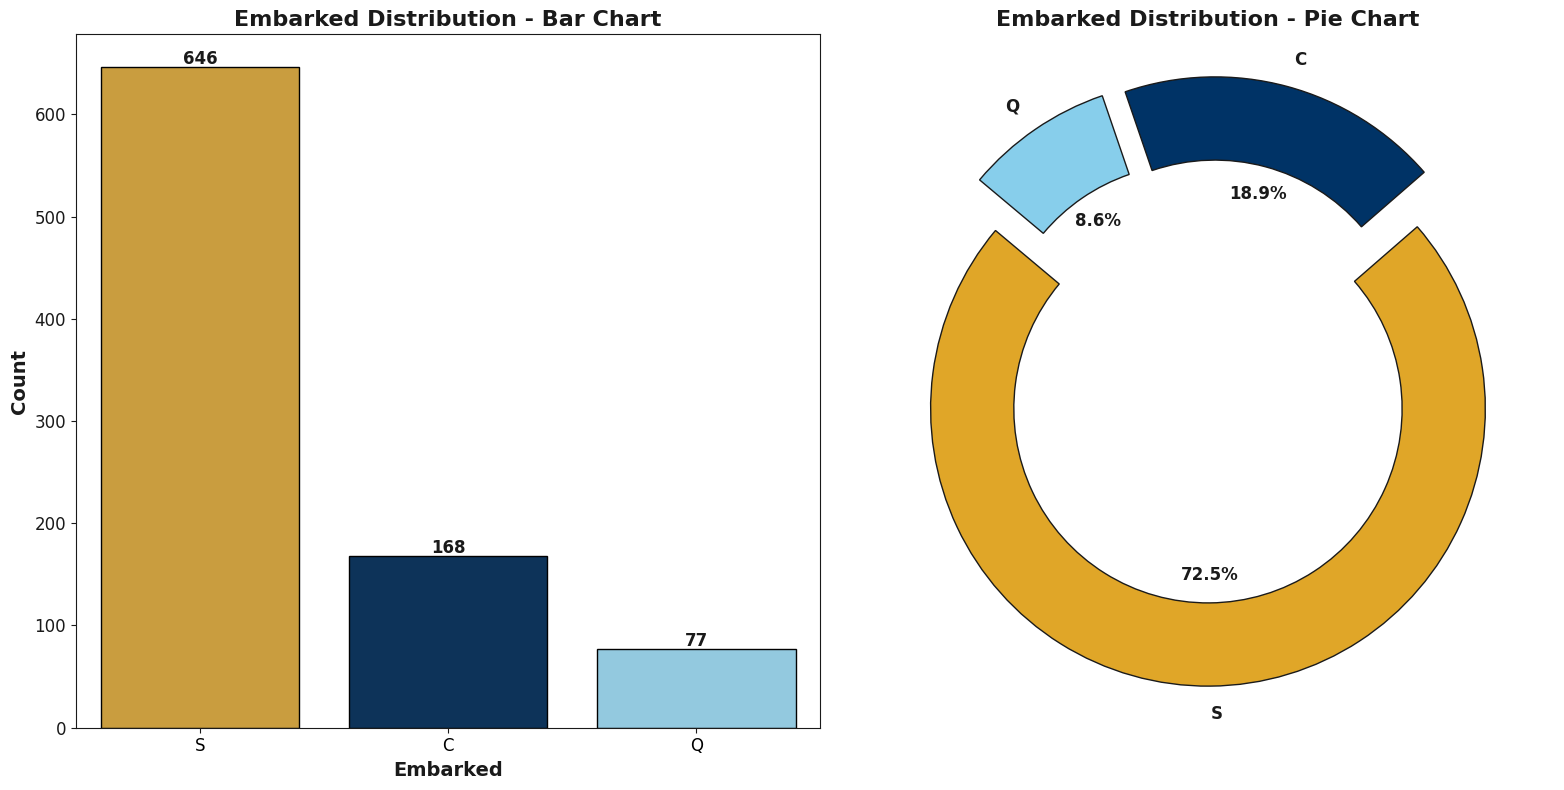

In [27]:
import pandas as pd

# Calculate the counts for 'Embarked'
embarked_counts = train['Embarked'].value_counts()

# Create a DataFrame for displaying counts
embarked_counts_df = pd.DataFrame({'Embarked': embarked_counts.index, 'Count': embarked_counts.values})

# Assuming you have a style_dataframe function defined elsewhere
styled_embarked_counts_df = style_dataframe(embarked_counts_df)

# Display the styled DataFrame
display(styled_embarked_counts_df)


colors = ['#E0A628', '#003366', '#87CEEB']

# Calculate the counts for 'Embarked'
embarked_counts = train['Embarked'].value_counts()
labels = embarked_counts.index

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Chart
sns.barplot(x=embarked_counts.index, y=embarked_counts.values, palette=colors[:len(embarked_counts)], ax=ax[0], edgecolor='black')
ax[0].set_xlabel('Embarked', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_title('Embarked Distribution - Bar Chart', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].tick_params(axis='x', labelsize=12, color='#1A1A1A', rotation=0)  # Rotate x labels for better readability
ax[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center", fontsize=12, fontweight='bold', color='#1A1A1A')

# Pie Chart
ax[1].pie(embarked_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors[:len(embarked_counts)], explode=(0.1,) * len(embarked_counts),
          textprops={'fontsize': 12, 'color': '#1A1A1A', 'weight': 'bold'}, wedgeprops=dict(width=0.3, edgecolor='#1A1A1A'))
ax[1].set_title('Embarked Distribution - Pie Chart', fontsize=16, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()


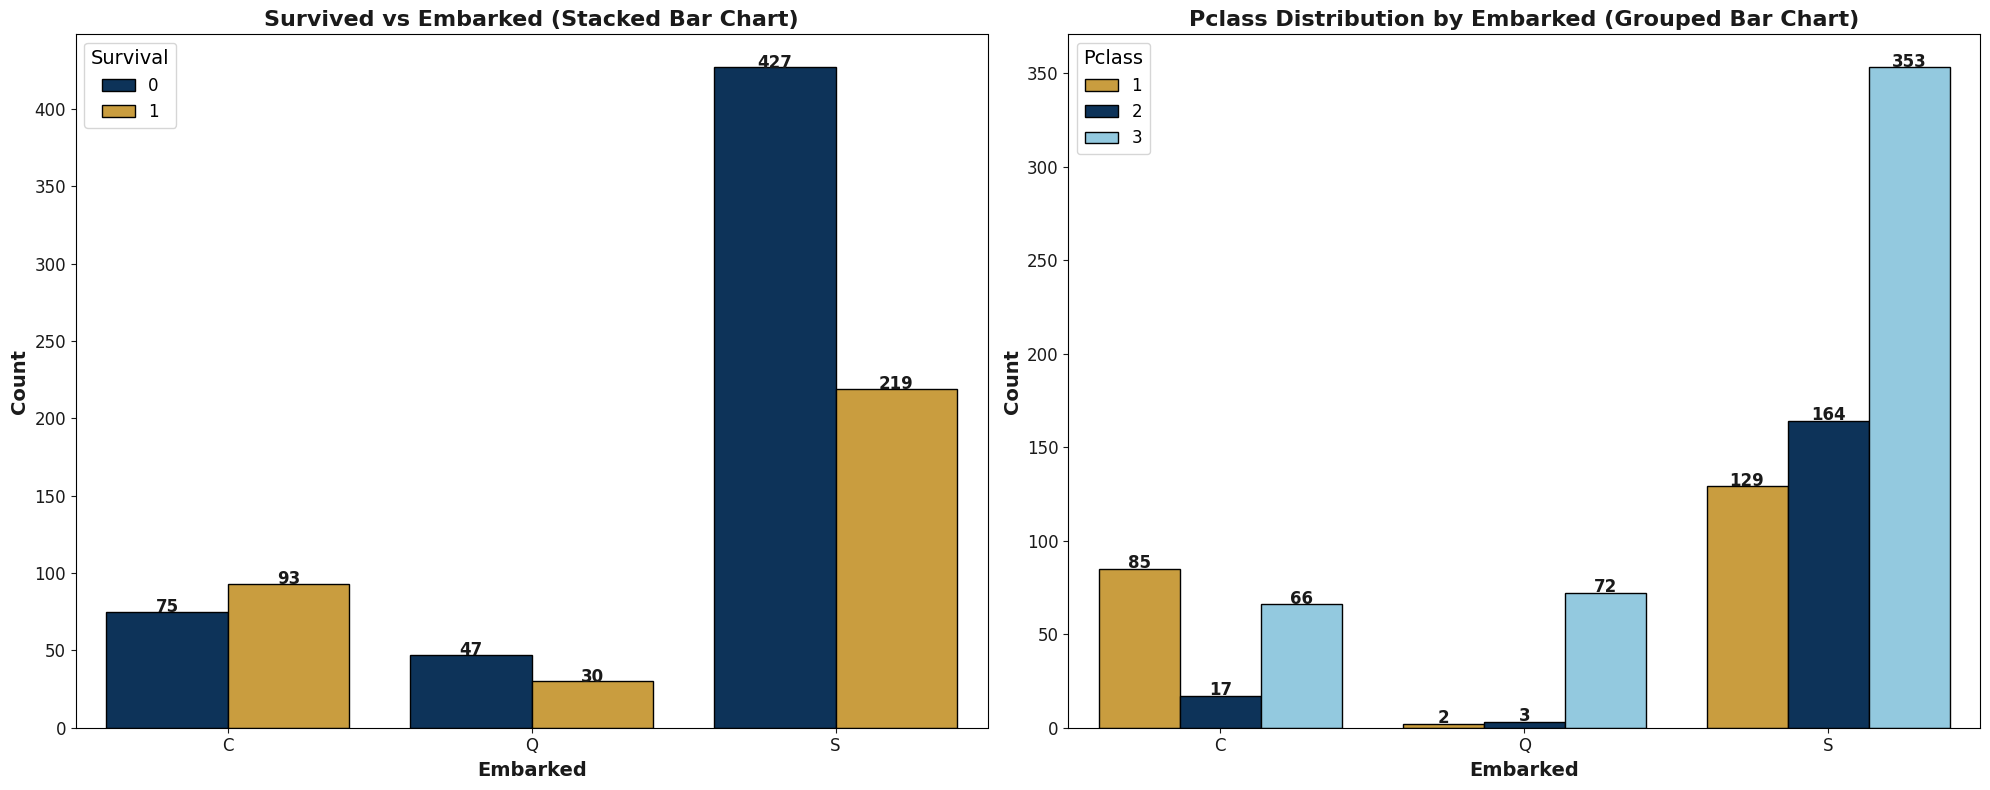

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the color schemes
colors_survived = ['#003366', '#E0A628']  # Colors for Not Survived and Survived
colors_pclass = ['#E0A628', '#003366', '#87CEEB']  # Colors for Pclass 1, 2, 3

# Data preparation for survived counts by embarkation
survived_by_embarked = train.groupby('Embarked')['Survived'].value_counts().unstack().fillna(0).reset_index()
survived_by_embarked_melted = survived_by_embarked.melt(id_vars='Embarked', value_vars=[0, 1], var_name='Survived', value_name='Count')

# Data preparation for class counts by embarkation
class_by_embarked = train.groupby('Embarked')['Pclass'].value_counts().unstack().fillna(0).reset_index()
class_by_embarked_melted = class_by_embarked.melt(id_vars='Embarked', value_vars=[1, 2, 3], var_name='Pclass', value_name='Count')

# Create the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Stacked Bar Chart for Survived vs Embarked
sns.barplot(x='Embarked', y='Count', hue='Survived', data=survived_by_embarked_melted, palette=colors_survived, ax=axes[0], edgecolor='black')
axes[0].set_xlabel('Embarked', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[0].set_title('Survived vs Embarked (Stacked Bar Chart)', fontsize=16, fontweight='bold', color='#1A1A1A')
axes[0].tick_params(axis='x', labelsize=12, colors='#1A1A1A')
axes[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
axes[0].legend(title='Survival', title_fontsize=14, fontsize=12, loc='upper left')

# Add labels to each bar segment
for p in axes[0].patches:
    height = p.get_height()
    if height > 0:
        axes[0].annotate(f'{int(height)}', 
                         (p.get_x() + p.get_width() / 2, p.get_height() + 3), 
                         ha='center', va='center', 
                         fontsize=12, fontweight='bold', color='#1A1A1A')

# Grouped Bar Chart for Pclass Distribution by Embarked
sns.barplot(x='Embarked', y='Count', hue='Pclass', data=class_by_embarked_melted, palette=colors_pclass, ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Embarked', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[1].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
axes[1].set_title('Pclass Distribution by Embarked (Grouped Bar Chart)', fontsize=16, fontweight='bold', color='#1A1A1A')
axes[1].tick_params(axis='x', labelsize=12, colors='#1A1A1A')
axes[1].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
axes[1].legend(title='Pclass', title_fontsize=14, fontsize=12, loc='upper left')

# Add labels to each bar segment
for p in axes[1].patches:
    height = p.get_height()
    if height > 0:
        axes[1].annotate(f'{int(height)}', 
                         (p.get_x() + p.get_width() / 2, p.get_height() + 3), 
                         ha='center', va='center', 
                         fontsize=12, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()


**Observations from the Charts:**

- **Survival by Embarkation:**
  - **Port C (Cherbourg):**
    - Port C seems to have the highest number of survivors, with a good mix of those who survived and those who didn’t.
    - It looks like people who boarded from Port C had a better survival rate overall compared to the other ports.
  - **Port Q (Queenstown):**
    - Port Q and Port S show fewer survivors, with Port S having more people who didn’t survive compared to Port Q.
  - **Port S (Southampton):**
    - Port S had a larger number of people who didn’t survive.

- **Class Distribution by Embarkation:**
  - **Port C:**
    - Port C has a good spread across all three classes, but a higher proportion of passengers in Pclass 1 (the highest class) compared to other ports.
  - **Port S:**
    - Port S mainly has people from Pclass 3 (the lowest class), indicating that more lower-class passengers boarded from here.
  - **Port Q:**
    - Port Q shows a mix but with a slightly higher number of Pclass 2 passengers.

**Overall, the charts suggest that:**

- **Cherbourg passengers** had both a higher survival rate and a greater presence in the higher social class (Pclass 1).
- **Southampton** had a large number of passengers in the lowest class (Pclass 3) and a lower survival rate, potentially due to the class disparities affecting survival chances.
- **Queenstown** had a more mixed class distribution with relatively better survival chances compared to Southampton but not as high as Cherbourg.


In [29]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

The code converts the 'Embarked' port codes ('S', 'C', 'Q') into numerical values (0, 1, 2)

## Parch Passengers: Did Parent/Child Ties Influence Titanic Survival? 👨‍👩‍👧‍👦

Let’s explore whether having family connections, like parents or children, on board influenced survival chances on the Titanic. Did those with family ties fare better in the face of disaster, or were they just as vulnerable as everyone else?

Parch,Count
0,678
1,118
2,80
5,5
3,5
4,4
6,1


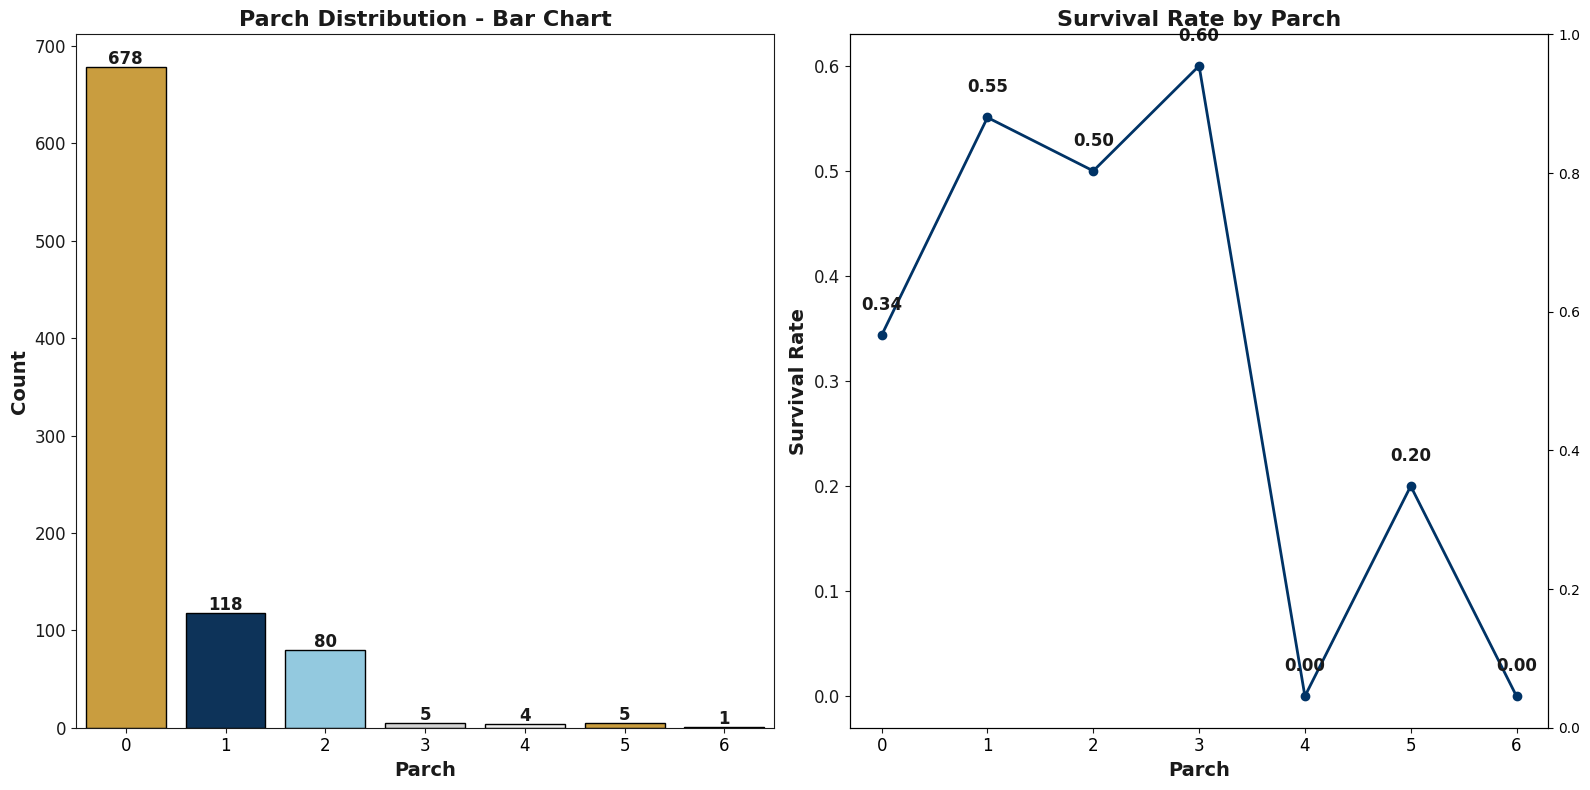

In [30]:
# Calculate the counts for 'Parch'
parch_counts = train['Parch'].value_counts()

# Create a DataFrame for displaying counts
parch_counts_df = pd.DataFrame({'Parch': parch_counts.index, 'Count': parch_counts.values})

styled_parch_counts_df = style_dataframe(parch_counts_df)

# Display the styled DataFrame
display(styled_parch_counts_df)

# Define the color scheme
colors = ['#E0A628', '#003366', '#87CEEB', '#D4D4D4', '#F0F0F0']

# Calculate the counts for 'Parch'
parch_counts = train['Parch'].value_counts()
parch_survival_rate = train.groupby('Parch')['Survived'].mean()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Chart for Parch Distribution
sns.barplot(x=parch_counts.index, y=parch_counts.values, palette=colors[:len(parch_counts)], ax=ax[0], edgecolor='black')
ax[0].set_xlabel('Parch', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_title('Parch Distribution - Bar Chart', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].tick_params(axis='x', labelsize=12, color='#1A1A1A')
ax[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center", fontsize=12, fontweight='bold', color='#1A1A1A')

# Line Chart for Survival Rate by Parch
ax2 = ax[1].twinx()
ax[1].plot(parch_survival_rate.index, parch_survival_rate.values, marker='o', color='#003366', label='Survival Rate', linewidth=2)
ax[1].set_xlabel('Parch', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[1].set_ylabel('Survival Rate', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[1].set_title('Survival Rate by Parch', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[1].tick_params(axis='x', labelsize=12, color='#1A1A1A')
ax[1].tick_params(axis='y', labelsize=12, colors='#1A1A1A')

# Add labels to each point on the line chart
for i, value in enumerate(parch_survival_rate.values):
    ax[1].text(parch_survival_rate.index[i], value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()

### Parch Distribution Bar Chart:

- **What it Shows:** How many passengers had each number of parents/children aboard (the `Parch` feature).
- **Takeaway:** Most passengers were either alone or had just one parent/child with them, with fewer having more family members.

### Survival Rate by Parch Line Chart:

- **What it Shows:** The average survival rate for passengers with different numbers of parents/children aboard.
- **Takeaway:** Survival rates vary with the number of family members. Generally, passengers with 1, 2, or 3 family members had a higher survival rate compared to those with none or more.

**In a Nutshell:** The bar chart helps us see the distribution of family sizes, while the line chart provides insights into how family size affected survival chances.


## Did Having Siblings/Spouses Boost Their Odds? 👫

This exploration dives into how having siblings or spouses aboard the Titanic might have influenced survival chances. 

SibSp,Count
0,608
1,209
2,28
4,18
3,16
8,7
5,5


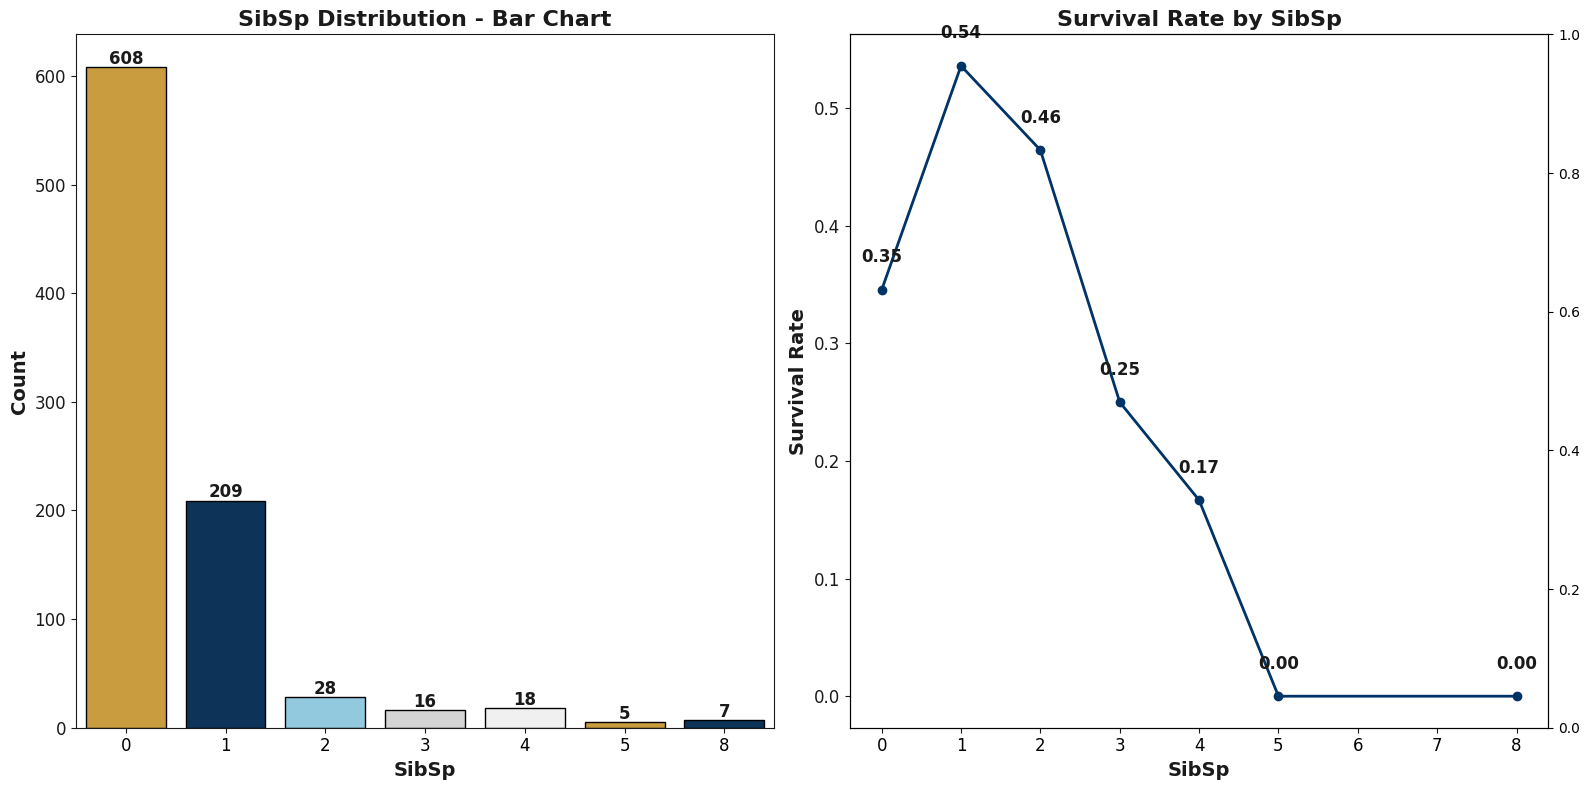

In [31]:
# Calculate the counts for 'SibSp'
sibsp_counts = train['SibSp'].value_counts()

# Create a DataFrame for displaying counts
sibsp_counts_df = pd.DataFrame({'SibSp': sibsp_counts.index, 'Count': sibsp_counts.values})

# Assuming you have a style_dataframe function defined elsewhere
styled_sibsp_counts_df = style_dataframe(sibsp_counts_df)

# Display the styled DataFrame
display(styled_sibsp_counts_df)

# Define the color scheme
colors = ['#E0A628', '#003366', '#87CEEB', '#D4D4D4', '#F0F0F0']

# Calculate the counts for 'SibSp'
sibsp_counts = train['SibSp'].value_counts()
sibsp_survival_rate = train.groupby('SibSp')['Survived'].mean()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Bar Chart for SibSp Distribution
sns.barplot(x=sibsp_counts.index, y=sibsp_counts.values, palette=colors[:len(sibsp_counts)], ax=ax[0], edgecolor='black')
ax[0].set_xlabel('SibSp', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[0].set_title('SibSp Distribution - Bar Chart', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[0].tick_params(axis='x', labelsize=12, color='#1A1A1A')
ax[0].tick_params(axis='y', labelsize=12, colors='#1A1A1A')
for spine in ax[0].spines.values():
    spine.set_edgecolor('#1A1A1A')

# Add labels to each bar
for p in ax[0].patches:
    ax[0].text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha="center", fontsize=12, fontweight='bold', color='#1A1A1A')

# Line Chart for Survival Rate by SibSp
ax2 = ax[1].twinx()
ax[1].plot(sibsp_survival_rate.index, sibsp_survival_rate.values, marker='o', color='#003366', label='Survival Rate', linewidth=2)
ax[1].set_xlabel('SibSp', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[1].set_ylabel('Survival Rate', fontsize=14, fontweight='bold', color='#1A1A1A')
ax[1].set_title('Survival Rate by SibSp', fontsize=16, fontweight='bold', color='#1A1A1A')
ax[1].tick_params(axis='x', labelsize=12, color='#1A1A1A')
ax[1].tick_params(axis='y', labelsize=12, colors='#1A1A1A')

# Add labels to each point on the line chart
for i, value in enumerate(sibsp_survival_rate.values):
    ax[1].text(sibsp_survival_rate.index[i], value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='#1A1A1A')

# Adjust the layout
plt.tight_layout()
plt.show()


**FamilySize Distribution and Survival Rate (Left Plot):**

- **Bar Chart:** 
  - **What it Shows:** The number of passengers with different family sizes.
  - **Takeaway:** Most passengers were either alone or had 1-2 family members.

- **Line Chart:** 
  - **What it Shows:** Survival rates for each family size.
  - **Takeaway:** Passengers with no family members had a lower survival rate compared to those with 1-2 family members. Survival rates tend to dip as family size increases beyond this range.

**IsAlone Distribution and Survival Rate (Right Plot):**

- **Bar Chart:** 
  - **What it Shows:** The count of passengers who were alone versus those with at least one family member.
  - **Takeaway:** There were more passengers who were not alone.

- **Line Chart:** 
  - **What it Shows:** Survival rates for those who were alone versus those who weren’t.
  - **Takeaway:** Passengers who were alone generally had a lower survival rate compared to those with family members.

**In Short:** The plots provide insights into how family size and being alone affected survival chances. It appears that having a small family or not being alone was associated with better survival rates.


## Family Ties or Solo Sails? 🛳️ How Having Kin or Solo Affected Titanic Survival

Here we add two new features FamilySize and IsAlone and see how they determine the survival rates

In [32]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

We’re adding a new feature called FamilySize to track how many family members each passenger had on board by adding SibSp (siblings/spouses) and Parch (parents/children), and then adding 1 for the passenger themselves.

Next, we’re creating another feature, IsAlone, to mark if someone was traveling alone. If FamilySize is 1, we set IsAlone to 1, indicating they were alone; otherwise, it stays 0. This helps us see how being alone or with family might affect survival chances.

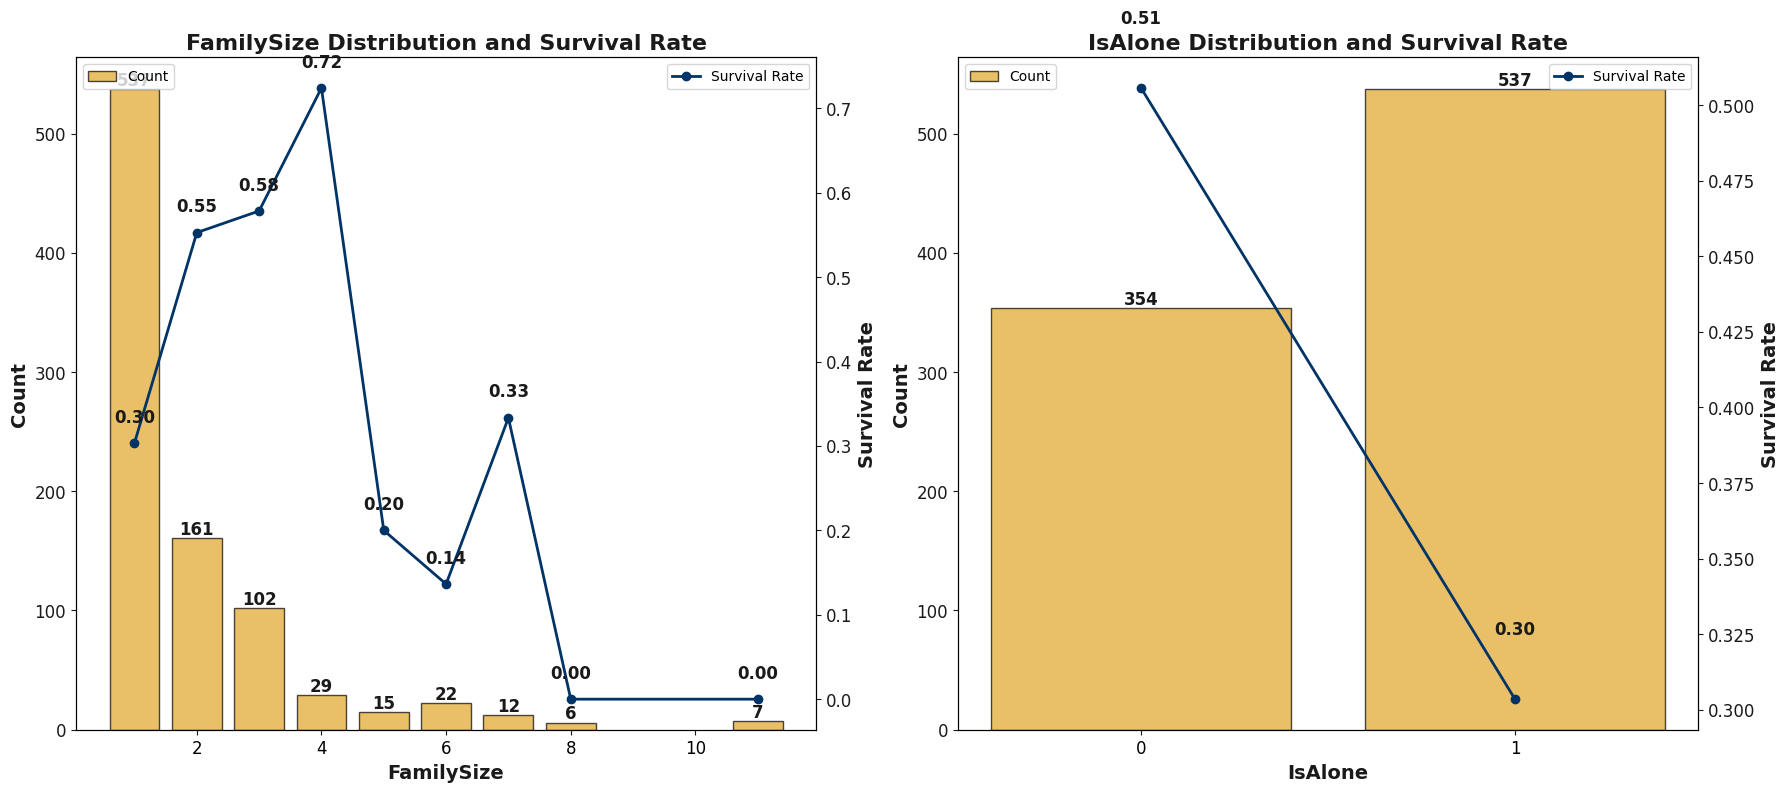

In [33]:
family_size_counts = train['FamilySize'].value_counts()
family_size_survival_rate = train.groupby('FamilySize')['Survived'].mean()

# Calculate counts and survival rates for IsAlone
is_alone_counts = train['IsAlone'].value_counts()
is_alone_survival_rate = train.groupby('IsAlone')['Survived'].mean()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# FamilySize vs. Survival Rate
ax1 = ax[0]
color_bar = '#E0A628'
color_line = '#003366'
ax1.bar(family_size_counts.index, family_size_counts.values, color=color_bar, edgecolor='black', alpha=0.7, label='Count')
ax1.set_xlabel('FamilySize', fontsize=14, fontweight='bold', color='#1A1A1A')
ax1.set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax1.set_title('FamilySize Distribution and Survival Rate', fontsize=16, fontweight='bold', color='#1A1A1A')
ax1.tick_params(axis='x', labelsize=12, color='#1A1A1A')
ax1.tick_params(axis='y', labelsize=12, colors='#1A1A1A')

# Add labels to each bar
for p in ax1.patches:
    ax1.text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha='center', fontsize=12, fontweight='bold', color='#1A1A1A')

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(family_size_survival_rate.index, family_size_survival_rate.values, marker='o', color=color_line, label='Survival Rate', linewidth=2)
ax2.set_ylabel('Survival Rate', fontsize=14, fontweight='bold', color='#1A1A1A')
ax2.tick_params(axis='y', labelsize=12, colors='#1A1A1A')

# Add labels to each point on the line plot
for i, value in enumerate(family_size_survival_rate.values):
    ax2.text(family_size_survival_rate.index[i], value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='#1A1A1A')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# IsAlone vs. Survival Rate
ax3 = ax[1]
color_bar = '#E0A628'
color_line = '#003366'
ax3.bar(is_alone_counts.index, is_alone_counts.values, color=color_bar, edgecolor='black', alpha=0.7, label='Count')
ax3.set_xlabel('IsAlone', fontsize=14, fontweight='bold', color='#1A1A1A')
ax3.set_ylabel('Count', fontsize=14, fontweight='bold', color='#1A1A1A')
ax3.set_title('IsAlone Distribution and Survival Rate', fontsize=16, fontweight='bold', color='#1A1A1A')
ax3.set_xticks([0, 1])  # Ensure x-axis only shows 0 and 1
ax3.tick_params(axis='x', labelsize=12, color='#1A1A1A')
ax3.tick_params(axis='y', labelsize=12, colors='#1A1A1A')

# Add labels to each bar
for p in ax3.patches:
    ax3.text(p.get_x() + p.get_width() / 2, p.get_height() + 3, f'{int(p.get_height())}', ha='center', fontsize=12, fontweight='bold', color='#1A1A1A')

# Create a second y-axis for the line plot
ax4 = ax3.twinx()
ax4.plot(is_alone_survival_rate.index, is_alone_survival_rate.values, marker='o', color=color_line, label='Survival Rate', linewidth=2)
ax4.set_ylabel('Survival Rate', fontsize=14, fontweight='bold', color='#1A1A1A')
ax4.tick_params(axis='y', labelsize=12, colors='#1A1A1A')

# Add labels to each point on the line plot
for i, value in enumerate(is_alone_survival_rate.values):
    ax4.text(is_alone_survival_rate.index[i], value + 0.02, f'{value:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='#1A1A1A')

# Add legends
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

# Adjust the layout
plt.tight_layout()
plt.show()

### FamilySize Plot

**Survival Rate by Family Size:**

- **Family Sizes 1 to 4:** These sizes show relatively high survival rates. This suggests that passengers with these family sizes had better chances of surviving, which might be due to factors like better access to lifeboats or quicker evacuation.
- **Family Sizes Above 4:** These show lower survival rates, which might indicate that larger family groups faced more difficulties during evacuation or were less likely to survive.

### IsAlone Plot

**Survival Rate for Being Alone vs. Not Alone:**

- **Being Alone:** Passengers who were alone have a higher survival rate compared to those who were not alone. This could imply that passengers traveling alone were able to move more quickly or were prioritized differently during the evacuation process.


In [34]:
# Feature selection
PassengerId = test['PassengerId']
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
#drop_elements = [ 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
test  = test.drop(drop_elements, axis = 1)


We're dropping these columns because they either aren't useful for our analysis or prediction model or they contain information that doesn’t help us predict survival. For instance, PassengerId is just an identifier, Name and Ticket are too specific, and Cabin has too many missing values. Removing SibSp simplifies our model by eliminating less relevant features. This helps focus on the data that truly impacts survival.

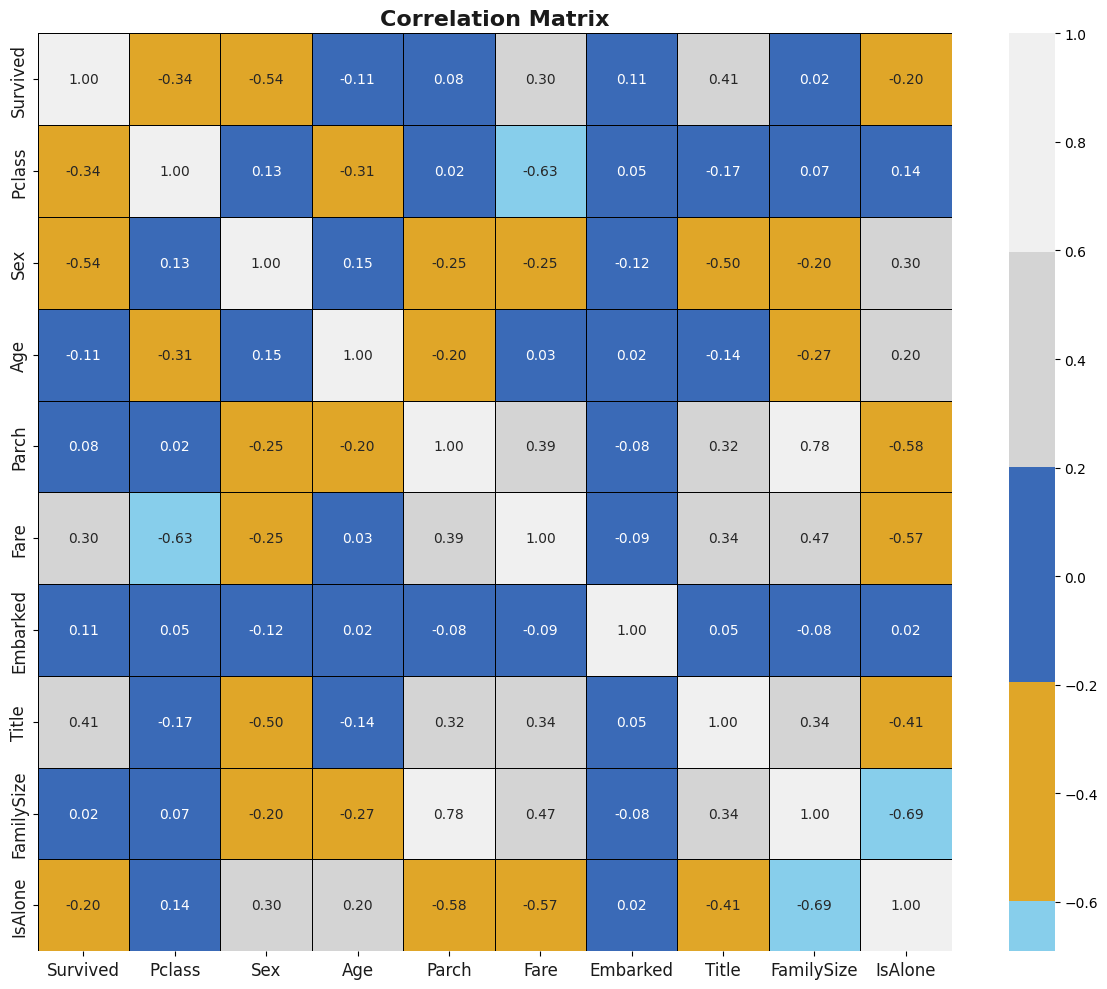

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = train.corr()

# Define the color scheme for the heatmap
colors = ['#87CEEB', '#E0A628', '#3A6AB7', '#D4D4D4', '#F0F0F0']

# Create a heatmap with the specified color scheme
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.color_palette(colors), fmt='.2f', center=0, linewidths=0.5, linecolor='black')

# Adjust titles and labels
plt.title('Correlation Matrix', fontsize=16, fontweight='bold', color='#1A1A1A')
plt.xticks(fontsize=12, color='#1A1A1A')
plt.yticks(fontsize=12, color='#1A1A1A')

# Show the plot
plt.tight_layout()
plt.show()

### Correlation Matrix Insights

This correlation matrix provides insights into how different features in our dataset relate to each other and to survival:

- **Survived**:
  - **Sex**: Most strongly negatively related to survival. Being female increases the chance of survival.
  - **Pclass**: Somewhat related to survival. Lower class (higher Pclass number) is associated with lower survival rates.

- **Fare**:
  - **Survival**: Positively correlated with survival. Higher fares tend to be associated with better survival chances.

- **FamilySize**:
  - **IsAlone**: Strong negative correlation. Larger family sizes are linked with not being alone.

Overall, the matrix helps us understand which features are more strongly associated with survival and how they interact with each other.


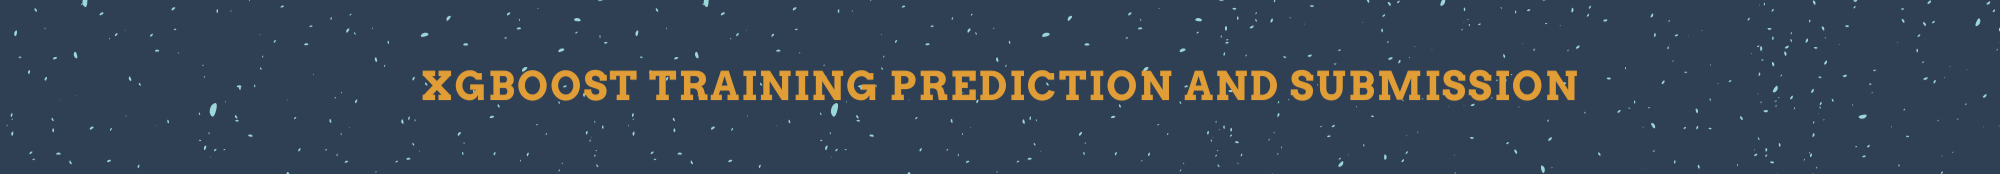

<p style="text-align: center; font-size: 20px; background-color: #E0A628; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #3A6AB7;">
   In this section, we train an XGBoost model to predict outcomes based on our dataset. We fine-tune the model through hyperparameter optimization to achieve the best performance. After training, we generate predictions and prepare the results for submission, ensuring our model's predictions are accurately formatted and ready for evaluation.
</p>


In [36]:
X = train.drop('Survived', axis=1)
y = train['Survived']

## XGBoost Model Training ⚙️

1. **Data Splitting**: The dataset is divided into training and validation sets with 80% for training and 20% for validation using `train_test_split`.

2. **Model Configuration**: An `XGBClassifier` is configured with specified hyperparameters (`xgb_params`) and a large number of boosting rounds (`n_estimators=12000`). The `eval_metric` is set to "auc" for evaluating performance.

3. **Model Training**: The model is trained on the training set (`X_train`, `y_train`) with validation data (`X_val`, `y_val`) used for monitoring. Training stops early if no improvement is observed in the validation set over 50 rounds, providing a safeguard against overfitting.


In [37]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
from xgboost import XGBClassifier
xgb_params = {
    "colsample_bylevel": 0.9268202748354142,
    "colsample_bynode": 0.9584021138317574,
    "colsample_bytree": 0.5015612007146208,
    "gamma": 0.3707206931090372,
    "grow_policy": "lossguide",
    "learning_rate": 0.03906159386409017,
    "max_depth": 16,
    "min_child_weight": 0.6117236350232369,
    "n_jobs": -1,
    "reg_alpha": 1.7264475728199302,
    "reg_lambda": 94.37990118781973,
    "subsample": 0.7599216762241778,
    "tree_method": "hist",
    "verbosity": 0
}
xgb_model = XGBClassifier(**xgb_params, n_estimators=12000, random_state=42, eval_metric="auc")
xgb_model.fit(
    X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50,verbose=500
)

[0]	validation_0-auc:0.70927
[359]	validation_0-auc:0.87458


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9268202748354142,
              colsample_bynode=0.9584021138317574,
              colsample_bytree=0.5015612007146208, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0.3707206931090372,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.03906159386409017,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=0.6117236350232369, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=12000, n_jobs=-1, num_parallel_tree=None,
              random_state=42, ...)

In [38]:
xgb_model.save_model("model.bin")

In [39]:
xgb_preds = xgb_model.predict(test)

## Confusion Matrix 🔢

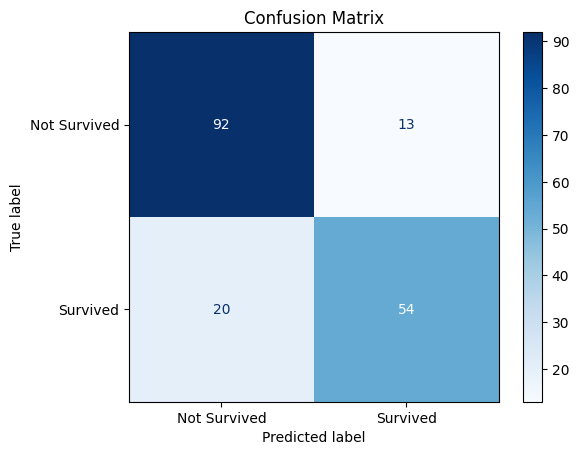

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and compute confusion matrix
y_val_preds = xgb_model.predict(X_val)
conf_matrix = confusion_matrix(y_val, y_val_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Survived', 'Survived'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## Submissions 📋

In [41]:
sub = pd.DataFrame()
sub['PassengerId'] = PassengerId
sub['Survived'] = xgb_preds

sub.head()
sub.to_csv("Submission.csv", index=False)

<p style="text-align: center; font-size: 20px; background-color: #E0A628; font-family: 'Comic Sans MS', cursive; padding: 20px; border-radius: 10px; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1); color: #3A6AB7;">
   This notebook dives into the Titanic dataset with a detailed Exploratory Data Analysis (EDA) and feature engineering. The EDA helps uncover interesting patterns and relationships in the data telling us a story, while feature engineering transforms and enhances the dataset to make it ready for modeling. Key steps include creating new features, handling different types of data, and preparing everything for the next stage. If you enjoyed this walkthrough and found the analysis valuable, please consider giving an upvote! Thank You!!
</p>